In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##ahh last shit lol

In [ ]:
thetas = pd.read_csv('/content/drive/MyDrive/senior_thesis/irt/final_combined_thetas.csv')
thetas.head()


,Model,IFEval,Parameters,LLMBar,MT Bench,JudgeBench,Comparison Task
0,gpt2-small,17.93,"137,000,000",NaN,NaN,NaN,-1.313103
1,gpt2-large,20.48,"812,000,000",NaN,NaN,NaN,-0.843485
2,llama-3.2-3b,13.37,"3,210,000,000",NaN,NaN,NaN,-1.006175
3,llama-3.2-1b-it,56.98,"1,240,000,000",-0.055270,2.197716,0.118551,-0.550444
4,llama-3.2-3b-it,73.93,"3,210,000,000",1.228031,2.477594,-0.104923,0.456605


In [ ]:
accuracies = pd.read_csv('/content/drive/MyDrive/senior_thesis/irt/combined_accuracies.csv')
accuracies.head()

,Model,LLMBar,MT Bench,JudgeBench,Comparison Task,Parameters
0,gpt2-small,NaN,NaN,NaN,37.0,"137,000,000"
1,gpt2-large,NaN,NaN,NaN,42.0,"812,000,000"
2,llama-3.2-3b,NaN,NaN,NaN,40.0,"1,240,000,000"
3,llama-3.2-1b-it,48.484848,47.619048,53.424658,45.0,"3,210,000,000"
4,llama-3.2-3b-it,63.636364,68.027211,41.095890,54.0,"3,210,000,000"


## grm pointwise stuff

In [ ]:
thetas = pd.read_csv('/content/drive/MyDrive/senior_thesis/irt/thetas_whole_rubric_2.csv')
thetas.head()


,Model,Overall Comparison,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,flan-t5-large,1.558274,0.904880,0.904880,0.904880,0.904879,0.904880,0.904880,0.904880
1,gemma-1.1-2b-it,1.732869,-3.534131,-3.229282,-3.435486,-3.239147,-3.275508,-3.295082,-2.419570
2,gemma-2-2b,NaN,1.350838,0.904955,1.350838,0.904880,1.350838,1.350838,1.350838
3,gemma-2-2b-it,2.027617,-3.534131,-3.229282,-3.435486,-3.239147,-3.275508,-3.295082,-2.419570
4,gemma-2b,1.519591,0.453740,0.453740,0.453740,0.453740,0.453740,0.453740,0.453740


Number of Theta columns after removing constants: 8
Error calculating p-value for Model and Overall Comparison: 'Model'
Error calculating p-value for Model and Overall: 'Model'
Error calculating p-value for Model and Cohesion: 'Model'
Error calculating p-value for Model and Syntax: 'Model'
Error calculating p-value for Model and Vocabulary: 'Model'
Error calculating p-value for Model and Phraseology: 'Model'
Error calculating p-value for Model and Grammar: 'Model'
Error calculating p-value for Model and Conventions: 'Model'
Error calculating p-value for Overall Comparison and Model: 'Model'
Error calculating p-value for Overall and Model: 'Model'
Error calculating p-value for Cohesion and Model: 'Model'
Error calculating p-value for Syntax and Model: 'Model'
Error calculating p-value for Vocabulary and Model: 'Model'
Error calculating p-value for Phraseology and Model: 'Model'
Error calculating p-value for Grammar and Model: 'Model'
Error calculating p-value for Conventions and Model: 

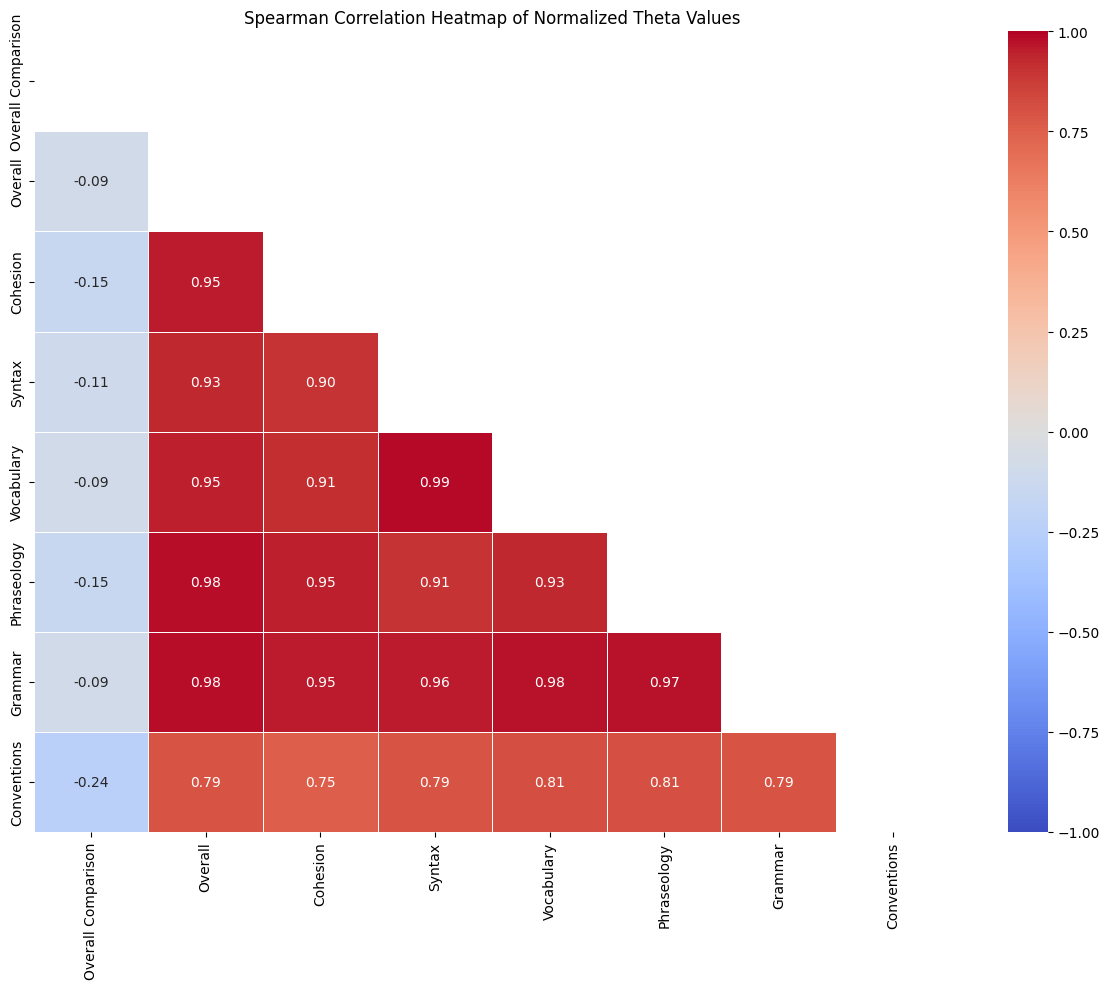

NaN values in correlation matrix: 0
NaN values in p-value matrix: 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Extract only the Theta columns
theta_cols = thetas.loc[:, ~thetas.columns.isin(['Model'])]

# Check for constant columns and remove them
non_constant_cols = []
for col in theta_cols:
    if thetas[col].nunique() > 1:  # Check if column has more than one unique value
        non_constant_cols.append(col)
    else:
        print(f"Warning: Removing constant column {col}")

# Sort columns alphabetically
theta_cols = non_constant_cols

# Print information about the columns
print(f"Number of Theta columns after removing constants: {len(theta_cols)}")

# # Handle missing values (if any)
theta_data = thetas[theta_cols].dropna()
# print(f"Rows before dropping NaN: {len(df)}, after: {len(theta_data)}")

# Normalize the data
scaler = StandardScaler()
theta_data_normalized = pd.DataFrame(
    scaler.fit_transform(theta_data),
    columns=theta_data.columns
)

# Calculate correlation matrix using Spearman
corr = theta_data_normalized.corr(method='spearman')

# Function to calculate p-values for Spearman correlation
def calculate_spearman_pvalues(df):
    df_cols = thetas.columns.tolist()
    n = len(df_cols)
    pvalues = np.ones((n, n))  # Initialize with ones (p=1)

    for i, col1 in enumerate(df_cols):
        for j, col2 in enumerate(df_cols):
            if i != j:  # Skip diagonal
                try:
                    # Handle potential warnings
                    with np.errstate(all='ignore'):
                        # Use Spearman correlation
                        stat, p = stats.spearmanr(df[col1], df[col2])

                    # Check if result is valid
                    if not np.isnan(p):
                        pvalues[i, j] = p
                except Exception as e:
                    print(f"Error calculating p-value for {col1} and {col2}: {str(e)}")
                    # Keep as p=1 (default, no significance)

    return pd.DataFrame(pvalues, index=df_cols, columns=df_cols)

# Calculate p-values using Spearman
p_values = calculate_spearman_pvalues(theta_data_normalized)

# Print the p-values matrix
print("\nP-value Matrix (Spearman):")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide display
print(p_values.round(3))

# Set up the figure
plt.figure(figsize=(12, 10))

# Create the heatmap
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create the heatmap with the mask
heatmap = sns.heatmap(corr,
                      mask=mask,
                      annot=True,
                      cmap='coolwarm',
                      vmin=-1, vmax=1,
                      fmt='.2f',
                      linewidths=0.5)


# # Add p-value annotations
# for i in range(len(corr.columns)):
#     for j in range(len(corr.columns)):
#         if i != j:  # Skip the diagonal
#             # Check significance level
#             if p_values.iloc[i, j] <= 0.05:
#                 # Add asterisks for significance
#                 if p_values.iloc[i, j] <= 0.001:
#                     sig = '***'
#                 elif p_values.iloc[i, j] <= 0.01:
#                     sig = '**'
#                 else:
#                     sig = '*'

#                 # Get coordinates of the cell
#                 x = j
#                 y = i

#                 # Add significance markers
#                 text = heatmap.axes.text(x + 0.5, y + 0.85, sig,
#                                          ha="center", va="baseline",
#                                          color="black", fontweight='bold')

# Adjust the title to reflect Spearman correlation
plt.title('Spearman Correlation Heatmap of Normalized Theta Values')
plt.tight_layout()

# Add a legend for significance levels
# plt.figtext(0.01, 0.01, "* p≤0.05, ** p≤0.01, *** p≤0.001", ha="left")

# Show the plot
plt.savefig('spearman_heatmap_normalized_thetas.png', bbox_inches='tight', dpi=600)
plt.show()

# Print NaN counts in both matrices
print(f"NaN values in correlation matrix: {np.isnan(corr.values).sum()}")
print(f"NaN values in p-value matrix: {np.isnan(p_values.values).sum()}")

## combining into one file

###accuracy


In [ ]:

import pandas as pd
import os
import re

filepath = '/content/drive/MyDrive/senior_thesis/irt/files'
all_files = [f for f in os.listdir(filepath) if f.endswith('_model_accuracies.csv')]

print(all_files)
combined_df = None

for file in all_files:
    print('hi')
    try:
      # Extract the suffix from the filename
      match = re.search(r"^(.*?)_model_accuracies", file)
      if not match:
          print(f"Warning: Skipping file '{file}' - unable to extract suffix.")
          continue
      suffix = match.group(1)

      df = pd.read_csv(os.path.join(filepath, file))

      if 'Model' not in df.columns:
          print(f"Warning: Skipping file '{file}' - 'model_name' column not found.")
          continue

      # Rename accuracy columns
      accuracy_cols = [col for col in df.columns if col != 'Model']
      for col in accuracy_cols:
          df = df.rename(columns={col: f'{col}_{suffix}'})

      if combined_df is None:
          combined_df = df
      else:
          combined_df = pd.merge(combined_df, df, on='Model', how='outer')
    except FileNotFoundError:
        print(f"Error: File '{file}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file}' is empty.")
        continue # Skip to next file
    except Exception as e:
      print(f"An error occurred while processing {file}: {e}")
      continue #Skip to next file


['llm_bar_model_accuracies.csv', 'mtbench_model_accuracies.csv', 'judgebench_model_accuracies.csv', 'comp_model_accuracies.csv']
hi
hi
hi
hi


In [ ]:
combined_df.to_csv('combined_accuracies.csv', index=False)

In [ ]:
print(combined_df)

    Unnamed: 0_llm_bar                       Model  Accuracy_llm_bar  \
0                  NaN                     flan-t5               NaN   
1                 20.0                flan-t5-base         46.969697   
2                 11.0               flan-t5-large         60.606061   
3                 21.0               flan-t5-small         46.969697   
4                  9.0                  flan-t5-xl         66.666667   
5                 17.0             gemma-1.1-2b-it         57.575758   
6                 14.0               gemma-2-2b-it         60.606061   
7                  NaN              gemma-2-2b_raw               NaN   
8                  NaN                    gemma-2b               NaN   
9                  NaN                    gemma-7b               NaN   
10                 NaN                  gpt2-large               NaN   
11                 NaN                 gpt2-medium               NaN   
12                 NaN                  gpt2-small              

### thetas


In [ ]:

import pandas as pd
import os
import re

filepath = '/content/drive/MyDrive/senior_thesis/irt/files'
all_files = [f for f in os.listdir(filepath) if f.endswith('_thetas.csv')]

print(all_files)
combined_df = None

for file in all_files:
    print('hi')
    try:
      match = re.search(r"^(.*?)_thetas", file)
      if not match:
          print(f"Warning: Skipping file '{file}' - unable to extract suffix.")
          continue
      suffix = match.group(1)

      df = pd.read_csv(os.path.join(filepath, file))

      if 'Model' not in df.columns:
          print(f"Warning: Skipping file '{file}' - 'model_name' column not found.")
          continue

      print(df.columns)
      theta_cols = [col for col in df.columns if 'Theta' in col]
      for col in theta_cols:
          df = df.rename(columns={col: f'{col}_{suffix}'})


      if combined_df is None:
          combined_df = df
      else:
          if 'IFEval' in df.columns:
              combined_df = pd.merge(combined_df, df, on=['Model', 'IFEval', 'Big_Bench_Hard', 'MuSR' ], how='outer')
          else:
              combined_df = pd.merge(combined_df, df, on='Model', how='outer')


    except FileNotFoundError:
        print(f"Error: File '{file}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file}' is empty.")
        continue
    except Exception as e:
      print(f"An error occurred while processing {file}: {e}")
      continue


['judgebench_thetas.csv', 'comp_thetas.csv', 'mtbench_thetas.csv', 'llmbar_thetas.csv']
hi
Index(['Model', 'IFEval', 'Big_Bench_Hard', 'MuSR', 'Theta_x', 'Theta_y'], dtype='object')
hi
Index(['Unnamed: 0', 'Model', 'IFEval', 'Big_Bench_Hard', 'MuSR', 'Theta_2pl',
       'Theta'],
      dtype='object')
hi
Index(['Unnamed: 0', 'Model', 'Theta', 'Theta_2pl'], dtype='object')
hi
Index(['Unnamed: 0', 'Model', 'IFEval', 'Big_Bench_Hard', 'MuSR', 'Theta_2pl',
       'Theta'],
      dtype='object')


In [ ]:
combined_df.to_csv('/content/drive/MyDrive/senior_thesis/irt/combined_thetas.csv', index=False)

In [ ]:
print(combined_df)

                    Model  IFEval  Big_Bench_Hard   MuSR  Theta_x_judgebench  \
0            flan-t5-base   18.91           11.34   3.22            0.178907   
1           flan-t5-large   22.01           17.51   9.01           -0.615643   
2           flan-t5-small   15.24            6.36  10.37            0.140559   
3              flan-t5-xl   22.37           22.70  11.33           -0.607931   
4         gemma-1.1-2b-it   30.67            5.86   2.02            0.228311   
5           gemma-2-2b-it   56.68           17.98   7.08           -0.015569   
6                gemma-2b   26.90            5.21   3.03                 NaN   
7                gemma-7b   26.59           21.12  10.98                 NaN   
8              gpt2-large   20.48            3.25   5.66                 NaN   
9             gpt2-medium    5.90           22.08   2.72                 NaN   
10             gpt2-small   17.93            2.67  15.35                 NaN   
11                gpt2-xl   20.39       

##graphing acc comp


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(
  '/content/drive/MyDrive/senior_thesis/irt/combined_accuracies.csv')
df.head()

,Model,LLMBar,MT Bench,JudgeBench,Comparison Task,Parameters
0,gpt2-small,NaN,NaN,NaN,37.0,"137,000,000"
1,gpt2-large,NaN,NaN,NaN,42.0,"812,000,000"
2,llama-3.2-3b,NaN,NaN,NaN,40.0,"1,240,000,000"
3,llama-3.2-1b-it,48.484848,47.619048,53.424658,45.0,"3,210,000,000"
4,llama-3.2-3b-it,63.636364,68.027211,41.095890,54.0,"3,210,000,000"


In [3]:
df = pd.read_csv(
  '/content/drive/MyDrive/senior_thesis/irt/final_combined_thetas.csv')
df.head()

,Model,IFEval,Parameters,LLMBar,MT Bench,JudgeBench,Comparison Task
0,gpt2-small,17.93,"137,000,000",NaN,NaN,NaN,-1.313103
1,gpt2-large,20.48,"812,000,000",NaN,NaN,NaN,-0.843485
2,llama-3.2-3b,13.37,"3,210,000,000",NaN,NaN,NaN,-1.006175
3,llama-3.2-1b-it,56.98,"1,240,000,000",-0.055270,2.197716,0.118551,-0.550444
4,llama-3.2-3b-it,73.93,"3,210,000,000",1.228031,2.477594,-0.104923,0.456605


In [ ]:
def get_model_family(model_name):
    if model_name.startswith('flan'):
        return 'flan-t5'
    elif model_name.startswith('gemma'):
        return 'gemma'
    elif model_name.startswith('gpt2'):
        return 'gpt2'
    elif model_name.startswith('llama'):
        return 'llama'
    elif model_name.startswith('mistral'):
        return 'mistral'
    elif model_name.startswith('olmo'):
        return 'olmo'
    elif model_name.startswith('phi'):
        return 'phi'
    elif model_name.startswith('qwen'):
        return 'qwen'
    else:
        return 'other'

df['Model_Family'] = df['Model'].apply(get_model_family)
df.head()

,Model,LLMBar,MT Bench,JudgeBench,Comparison Task,Parameters,Model_Family
0,gpt2-small,NaN,NaN,NaN,37.0,"137,000,000",gpt2
1,gpt2-large,NaN,NaN,NaN,42.0,"812,000,000",gpt2
2,llama-3.2-3b,NaN,NaN,NaN,40.0,"1,240,000,000",llama
3,llama-3.2-1b-it,48.484848,47.619048,53.424658,45.0,"3,210,000,000",llama
4,llama-3.2-3b-it,63.636364,68.027211,41.095890,54.0,"3,210,000,000",llama


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape data from wide to long format
benchmark_columns = [col for col in df.columns if col not in ['Model', 'Model_Family', 'Parameters', 'IFEval']]
long_df = pd.melt(df,
                  id_vars=['Model', 'Model_Family'],
                  value_vars=benchmark_columns,
                  var_name='Benchmark',
                  value_name='Accuracy')
long_df

,Model,Model_Family,Benchmark,Accuracy
0,gpt2-small,gpt2,LLMBar,NaN
1,gpt2-large,gpt2,LLMBar,NaN
2,llama-3.2-3b,llama,LLMBar,NaN
3,llama-3.2-1b-it,llama,LLMBar,48.484848
4,llama-3.2-3b-it,llama,LLMBar,63.636364
...,...,...,...,...
103,mistral-8b-it-2410,mistral,Comparison Task,76.000000
104,mistral-nemo-it-2407,mistral,Comparison Task,77.000000
105,gemma-2b,gemma,Comparison Task,64.000000
106,gemma-1.1-2b-it,gemma,Comparison Task,69.000000


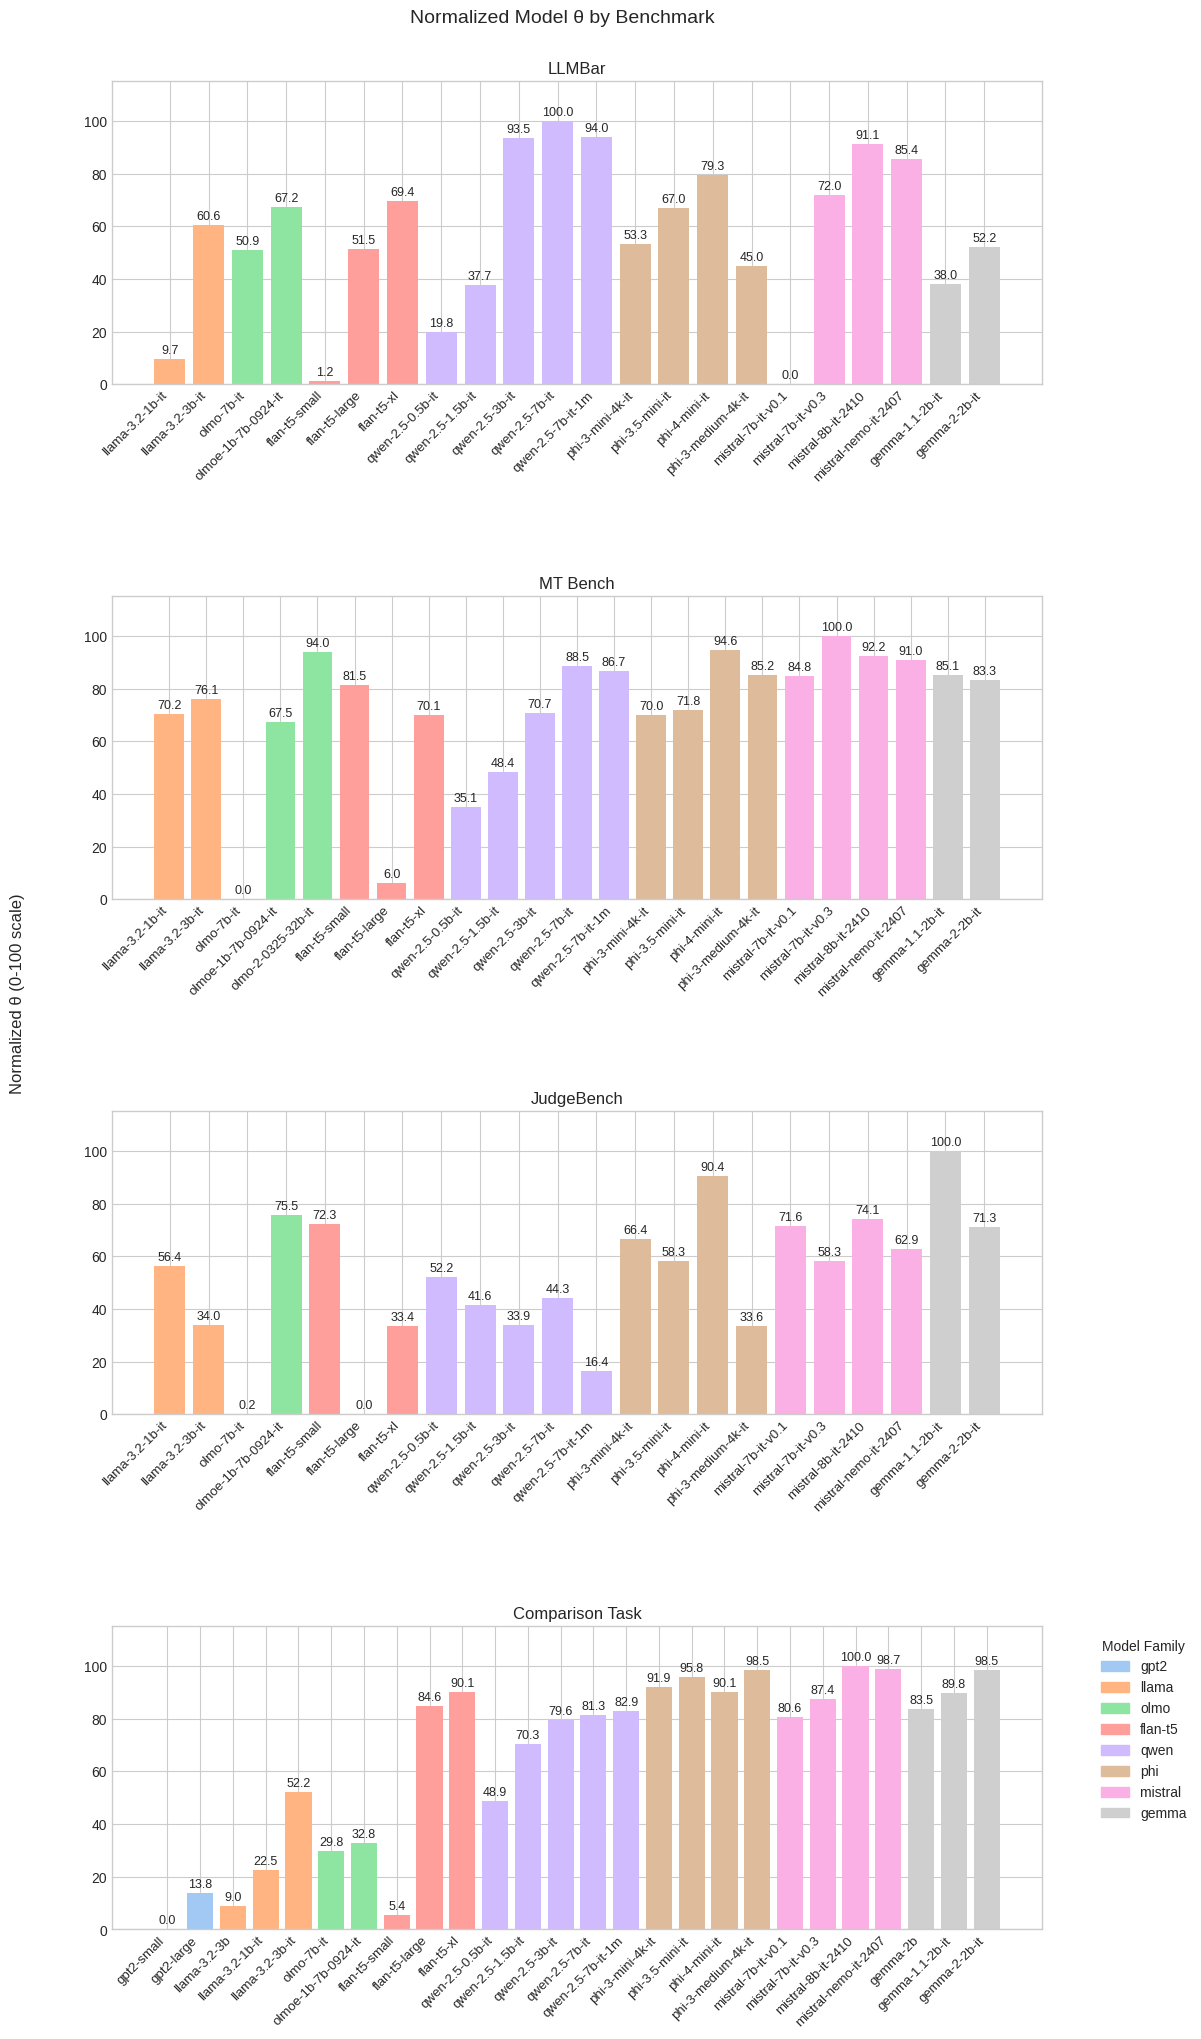

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Apply styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# Function to normalize values within each benchmark to a positive scale (0-100)
def normalize_benchmark(values):
    """Normalize values to 0-100 scale, handling negative values correctly"""
    values = pd.to_numeric(values, errors='coerce')
    values = values.dropna()

    if len(values) == 0:
        return values

    min_val = np.min(values)
    max_val = np.max(values)

    # If all values are the same, return array of 100s
    if max_val == min_val:
        return np.ones_like(values) * 100

    # If min is negative, shift all values to make minimum = 0
    if min_val < 0:
        shifted = values - min_val  # Now min becomes 0
        # Scale to 0-100 range
        return (shifted / np.max(shifted)) * 100
    else:
        # Already positive, just scale to 0-100
        return (values - min_val) / (max_val - min_val) * 100

# Apply normalization to each benchmark separately
for benchmark in long_df['Benchmark'].unique():
    # Get the indices of rows for this benchmark
    benchmark_indices = long_df[long_df['Benchmark'] == benchmark].index

    # Skip if no data for this benchmark
    if len(benchmark_indices) == 0:
        continue

    # Get the values for this benchmark
    benchmark_values = pd.to_numeric(long_df.loc[benchmark_indices, 'Theta'], errors='coerce')

    # Skip if all values are NaN
    if benchmark_values.isna().all():
        continue

    # Apply normalization
    normalized_values = normalize_benchmark(benchmark_values)

    # Update the values in the long_df DataFrame
    long_df.loc[benchmark_indices, 'Theta'] = normalized_values

# Get unique benchmarks
benchmarks = long_df['Benchmark'].unique()

# Calculate figure width based on number of models
n_models = len(df['Model'].unique())
fig_width = min(12, n_models*1.3)  # Minimum width of 12, but scales with model count

# Create a horizontal row of subplots (one per benchmark)
fig, axes = plt.subplots(len(benchmarks), 1, figsize=(fig_width, 6*len(benchmarks)), sharey=False)  # Changed sharey to False

# If there's only one benchmark, axes won't be an array, so we convert it
if len(benchmarks) == 1:
    axes = [axes]

# Get ALL unique model families across all benchmarks for consistent color mapping
all_model_families = long_df['Model_Family'].unique()
colors = sns.color_palette("pastel", len(all_model_families))
global_family_color_map = dict(zip(all_model_families, colors))

# For each benchmark, create a subplot
for i, benchmark in enumerate(benchmarks):
    # Filter data for this benchmark - only include rows where the model has data for this benchmark
    benchmark_data = long_df[long_df['Benchmark'] == benchmark].dropna(subset=['Theta'])

    # If there's no data for this benchmark, skip or show empty plot
    if len(benchmark_data) == 0:
        ax = axes[i]
        ax.text(0.5, 0.5, f"No data for {benchmark}",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(benchmark, fontsize=12)
        continue

    # Get current axis
    ax = axes[i]

    # Use the global color map instead of creating a new one for each benchmark
    bar_colors = [global_family_color_map[family] for family in benchmark_data['Model_Family']]

    # Create position indices (0, 1, 2, ...) for the bars - continuously numbered without gaps
    positions = np.arange(len(benchmark_data))

    # Create the bar chart using continuous positions
    bars = ax.bar(positions, benchmark_data['Theta'], color=bar_colors)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    # Set title for this subplot
    ax.set_title(benchmark, fontsize=12)

    # Set y-axis scale for this plot - each plot can have its own scale now
    max_value = max(benchmark_data['Theta']) if len(benchmark_data['Theta']) > 0 else 100
    ax.set_ylim(0, max_value * 1.15)  # Add 15% padding

    # Set x-axis ticks and labels - using the continuous positions
    ax.set_xticks(positions)
    ax.set_xticklabels(benchmark_data['Model'].values, rotation=45, ha='right', fontsize=9.5)

# Create a GLOBAL legend for model families (only on the last subplot)
handles = [plt.Rectangle((0,0),1,1, color=global_family_color_map[family]) for family in all_model_families]
axes[-1].legend(handles, all_model_families, title="Model Family", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a common y-label for all subplots
fig.text(0.04, 0.5, 'Normalized θ (0-100 scale)', va='center', rotation='vertical', fontsize=12)

# Add overall title
fig.suptitle('Normalized Model θ by Benchmark', fontsize=14, y=0.91)
plt.subplots_adjust(hspace=0.7)
plt.savefig('model_theta_benchmarks.png', bbox_inches='tight', dpi=600)

plt.show()

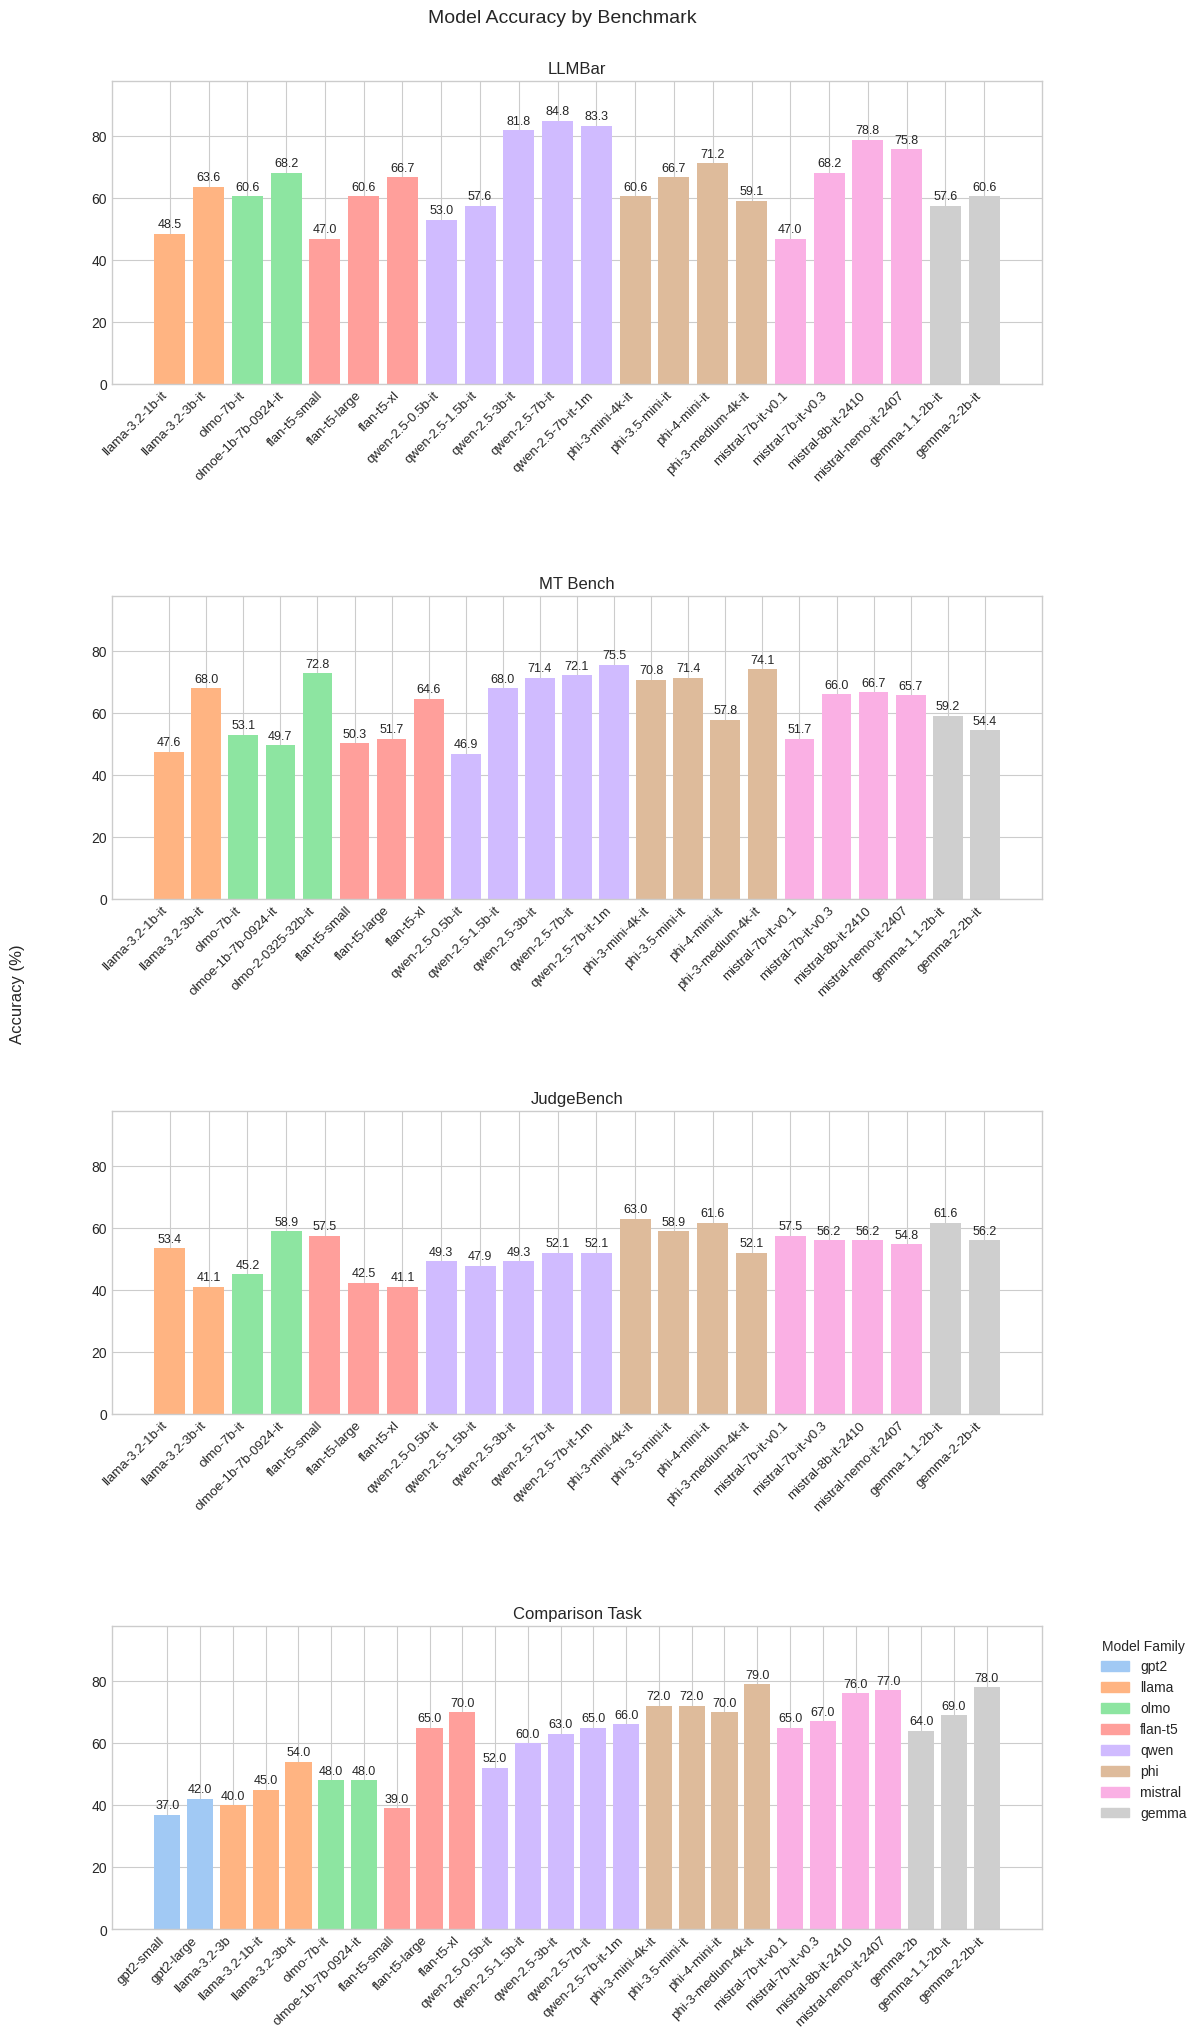

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# Get unique benchmarks
benchmarks = long_df['Benchmark'].unique()

# Calculate figure width based on number of models
n_models = len(df['Model'].unique())
fig_width = min(12, n_models*1.3)  # Minimum width of 12, but scales with model count

# Create a horizontal row of subplots (one per benchmark)
fig, axes = plt.subplots(len(benchmarks), 1, figsize=(fig_width, 6*len(benchmarks)), sharey=True)

# If there's only one benchmark, axes won't be an array, so we convert it
if len(benchmarks) == 1:
    axes = [axes]

# First, get the global maximum accuracy for consistent y-axis scaling
numeric_accuracy = pd.to_numeric(long_df['Accuracy'], errors='coerce')
max_accuracy = np.nanmax(numeric_accuracy) if not np.isnan(np.nanmax(numeric_accuracy)) else 100

# Get ALL unique model families across all benchmarks for consistent color mapping
all_model_families = long_df['Model_Family'].unique()
colors = sns.color_palette("pastel", len(all_model_families))
global_family_color_map = dict(zip(all_model_families, colors))

# For each benchmark, create a subplot
for i, benchmark in enumerate(benchmarks):
    # Filter data for this benchmark - only include rows where the model has data for this benchmark
    benchmark_data = long_df[long_df['Benchmark'] == benchmark].dropna(subset=['Accuracy'])

    # If there's no data for this benchmark, skip or show empty plot
    if len(benchmark_data) == 0:
        ax = axes[i]
        ax.text(0.5, 0.5, f"No data for {benchmark}",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(benchmark, fontsize=12)
        continue

    # Get current axis
    ax = axes[i]

    # Use the global color map instead of creating a new one for each benchmark
    bar_colors = [global_family_color_map[family] for family in benchmark_data['Model_Family']]

    # Create position indices (0, 1, 2, ...) for the bars - continuously numbered without gaps
    positions = np.arange(len(benchmark_data))

    # Create the bar chart using continuous positions
    bars = ax.bar(positions, benchmark_data['Accuracy'], color=bar_colors)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    # Set title for this subplot
    ax.set_title(benchmark, fontsize=12)

    # Set consistent y-axis scale across all plots
    ax.set_ylim(0, max_accuracy * 1.15)

    # Set x-axis ticks and labels - using the continuous positions
    ax.set_xticks(positions)
    ax.set_xticklabels(benchmark_data['Model'].values, rotation=45, ha='right', fontsize=9.5)

# Create a GLOBAL legend for model families (only on the last subplot)
handles = [plt.Rectangle((0,0),1,1, color=global_family_color_map[family]) for family in all_model_families]
axes[-1].legend(handles, all_model_families, title="Model Family", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a common y-label for all subplots
fig.text(0.04, 0.5, 'Accuracy (%)', va='center', rotation='vertical', fontsize=12)

# Add overall title
fig.suptitle('Model Accuracy by Benchmark', fontsize=14, y=0.91)
plt.subplots_adjust(hspace=0.7)
plt.savefig('model_accuracy_benchmarks.png', bbox_inches='tight', dpi=600)

plt.show()

Flan-t5


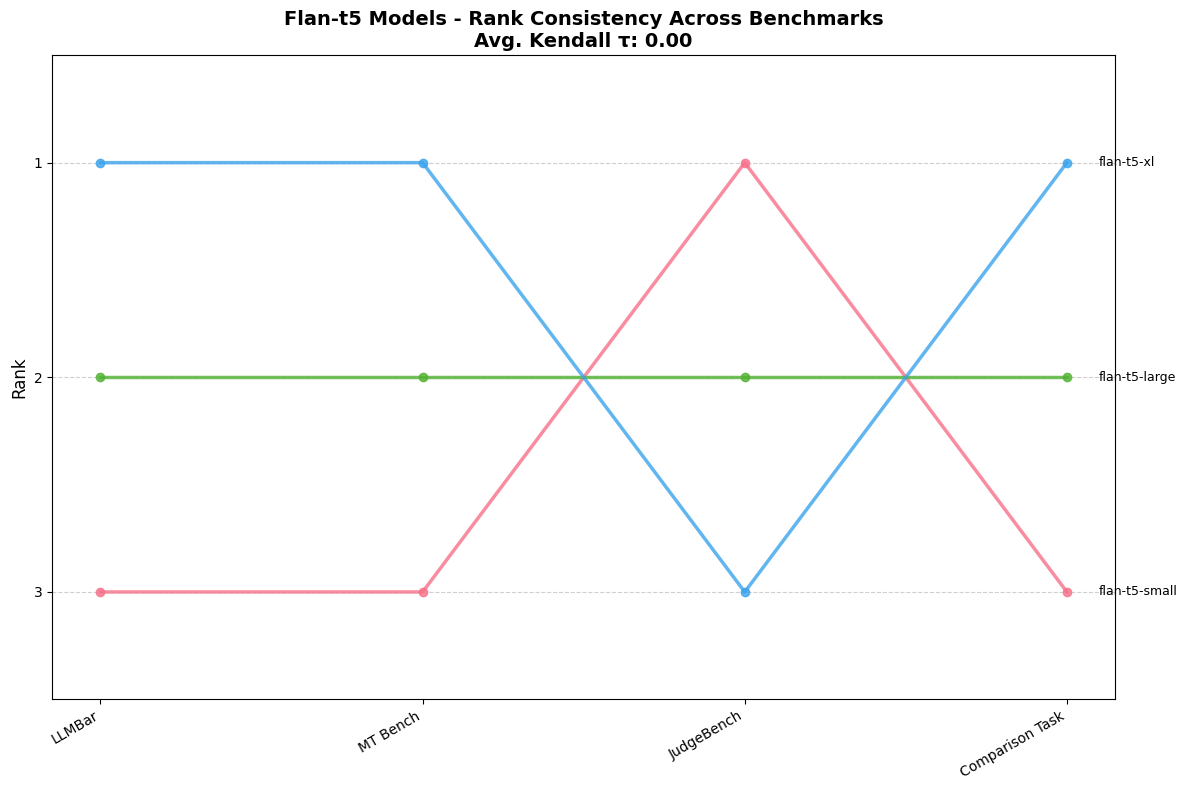

Mistral


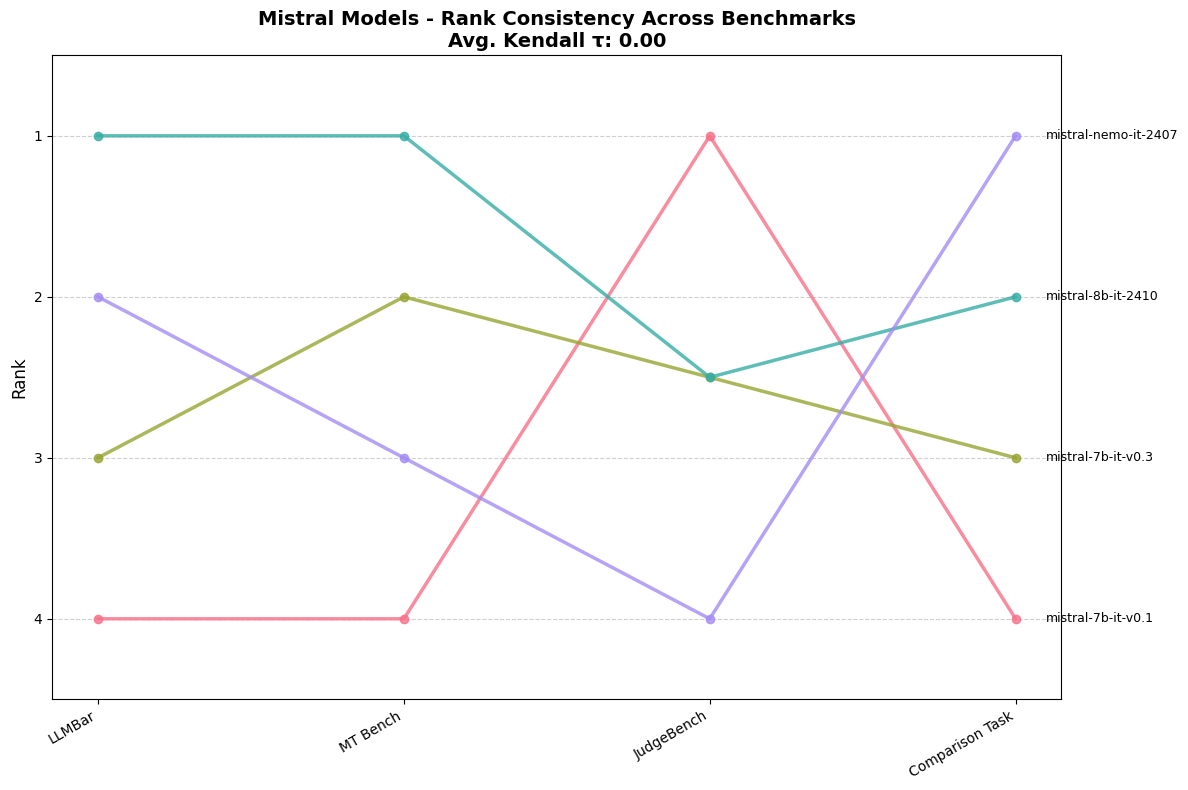

Phi


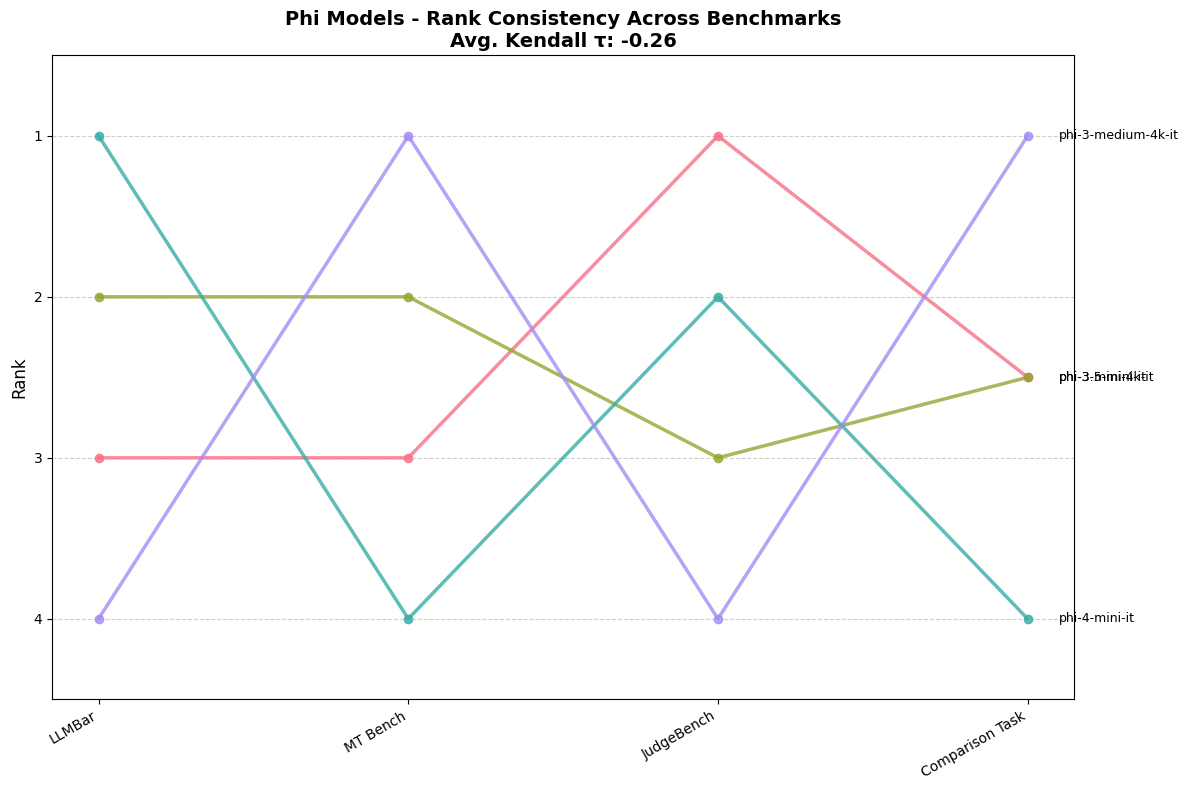

Qwen


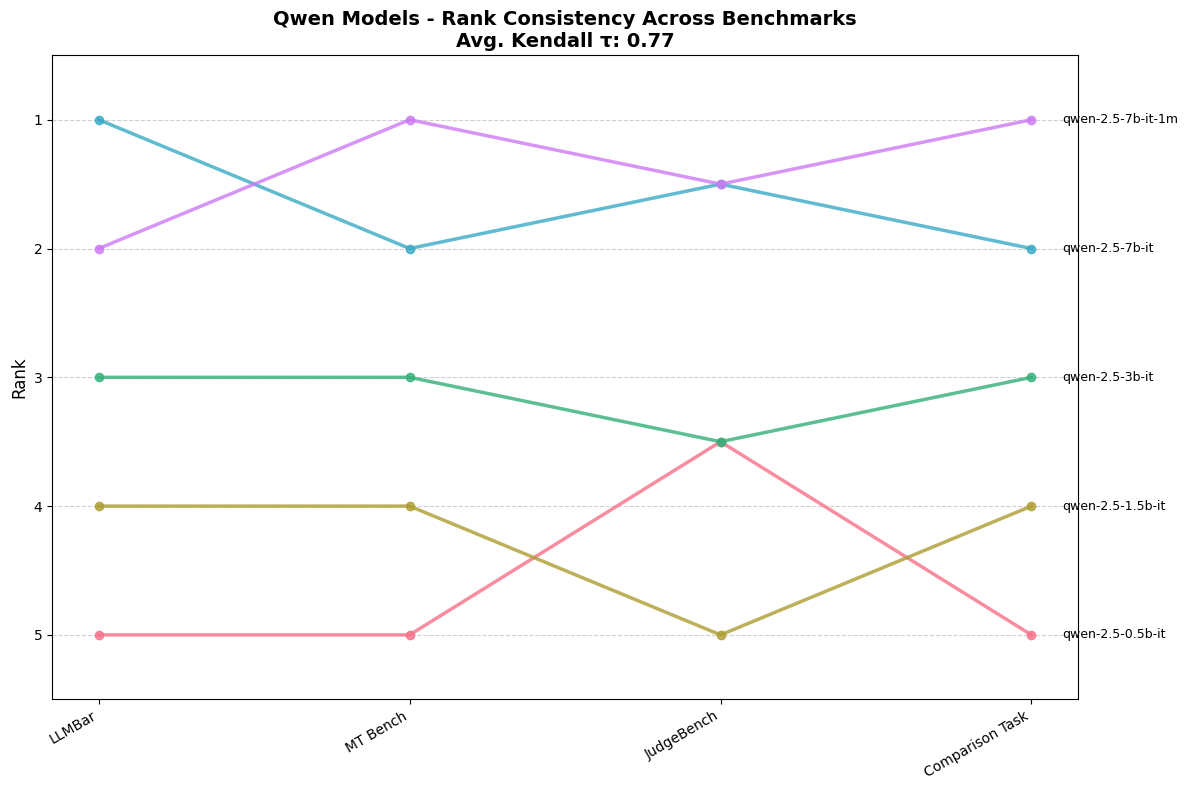

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def visualize_rank_consistency(df):
    """
    Creates a slope graph to show how model rankings change
    across different benchmarks.

    Parameters:
    df: DataFrame with columns 'Model', 'Model_Family', 'Parameters', and benchmark scores
    """
    # Filter to only include the requested model families
    requested_families = ['mistral', 'flan-t5', 'phi', 'qwen']

    # Create case-insensitive filter for model families
    df_filtered = df[df['Model_Family'].str.lower().isin([family.lower() for family in requested_families])]

    benchmark_cols = [col for col in df_filtered.columns if col not in ['Model', 'Model_Family', 'Parameters']]

    # Create a figure for each model family
    for family in sorted(df_filtered['Model_Family'].unique()):
        family_data = df_filtered[df_filtered['Model_Family'] == family]

        if len(family_data) < 2 or len(benchmark_cols) < 2:  # Changed from 3 to 2 to be more flexible
            print(f"Skipping {family}: not enough models or benchmarks")
            continue

        # Calculate ranks for each benchmark
        ranks_df = pd.DataFrame(index=family_data.index)

        for col in benchmark_cols:
            ranks_df[col] = family_data[col].rank(ascending=False)

        ranks_df['Model'] = family_data['Model']

        # For better visualization, limit to max 5 benchmarks if there are more
        if len(benchmark_cols) > 5:
            # Select a representative sample of benchmarks
            selected_benchmarks = benchmark_cols[:5]
        else:
            selected_benchmarks = benchmark_cols

        # Prepare figure
        fig, ax = plt.subplots(figsize=(12, max(8, len(family_data) * 0.8)))

        # Clean benchmark names
        clean_names = [col.replace('Accuracy_', '') for col in selected_benchmarks]

        # Set up x-axis
        x_positions = np.arange(len(selected_benchmarks))
        ax.set_xticks(x_positions)
        ax.set_xticklabels(clean_names, fontsize=10, rotation=30, ha='right')

        # Set y-axis (ranks are inverted so rank 1 is at the top)
        max_rank = len(family_data)
        ax.set_ylim(max_rank + 0.5, 0.5)  # Add padding
        ax.set_yticks(np.arange(1, max_rank + 1))
        ax.set_ylabel('Rank', fontsize=12)

        # Use a color palette that distinguishes models well
        palette = sns.color_palette("husl", len(family_data))

        # Draw lines between benchmarks to show rank changes
        for i, idx in enumerate(family_data.index):
            model = family_data.loc[idx, 'Model']
            model_ranks = [ranks_df.loc[idx, col] for col in selected_benchmarks]

            # Draw the slope graph lines
            ax.plot(x_positions, model_ranks, '-o', linewidth=2.5,
                   color=palette[i], alpha=0.8, label=model)

            # Add model name labels at the end
            ax.text(x_positions[-1] + 0.1, model_ranks[-1], model,
                   ha='left', va='center', fontsize=9)

        # Calculate Kendall tau correlations between each pair of benchmarks
        correlations = []
        for j, col1 in enumerate(selected_benchmarks):
            for k, col2 in enumerate(selected_benchmarks):
                if j < k:  # Only unique pairs
                    corr, _ = stats.kendalltau(family_data[col1], family_data[col2])
                    if not np.isnan(corr):
                        correlations.append(corr)

        avg_corr = np.mean(correlations) if correlations else np.nan

        name = family[0].upper() + family[1:]
        print(name)
        # Add title with correlation information
        ax.set_title(f"{name} Models - Rank Consistency Across Benchmarks\nAvg. Kendall τ: {avg_corr:.2f}",
                    fontsize=14, fontweight='bold')

        # Add grid for readability
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig(f'{name}_accuracy_rank_consistency.png', bbox_inches='tight', dpi=600)
        plt.show()  # Show each family plot individually

    return fig

# Use the function with the filtered families
# df = pd.read_csv(
#   '/content/drive/MyDrive/senior_thesis/irt/combined_accuracies.csv')

fig_rank = visualize_rank_consistency(df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Extract only the accuracy columns
accuracy_cols = df.loc[:, ~df.columns.isin(['Model', 'Model_Family', 'Parameters'])]

# Sort columns alphabetically
accuracy_cols = sorted(accuracy_cols)
accuracy_data = df[accuracy_cols]

# Calculate correlation matrix using Spearman instead of Pearson
corr = accuracy_data.corr(method='spearman')

# Function to calculate p-values for Spearman correlation
def calculate_spearman_pvalues(df):
    df_cols = df.columns.tolist()
    n = len(df_cols)
    pvalues = np.ones((n, n))  # Initialize with ones (p=1)

    for i, col1 in enumerate(df_cols):
        for j, col2 in enumerate(df_cols):
            if i != j:  # Skip diagonal
                try:
                    # Use Spearman correlation
                    stat, p = stats.spearmanr(df[col1], df[col2])
                    pvalues[i, j] = p
                except Exception as e:
                    print(f"Error calculating p-value for {col1} and {col2}: {str(e)}")
                    pvalues[i, j] = 1.0  # Default to no significance
            else:
                pvalues[i, j] = 1.0  # p-value for self correlation is 1

    return pd.DataFrame(pvalues, index=df_cols, columns=df_cols)

# Calculate p-values using Spearman
p_values = calculate_spearman_pvalues(accuracy_data)

# Print the p-values matrix
print("\nP-value Matrix (Spearman):")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide display
print(p_values.round(3))

# Set up the figure
plt.figure(figsize=(12, 10))

# Create the heatmap WITHOUT the mask
heatmap = sns.heatmap(corr,
                      annot=True,
                      cmap='coolwarm',
                      vmin=-1, vmax=1,
                      fmt='.2f',
                      linewidths=0.5)

# Add p-value annotations
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j:  # Skip the diagonal
            # Check significance level
            if p_values.iloc[i, j] <= 0.05:
                # Add asterisks for significance
                if p_values.iloc[i, j] <= 0.001:
                    sig = '***'
                elif p_values.iloc[i, j] <= 0.05:
                    sig = '**'
                else:
                    sig = '*'

                # Get coordinates of the cell
                x = j
                y = i

                # Add significance markers
                text = heatmap.axes.text(x + 0.5, y + 0.85, sig,
                                         ha="center", va="baseline",
                                         color="black", fontweight='bold')

# Adjust the title to reflect Spearman correlation
plt.title('Spearman Correlation Heatmap of Model Accuracies')
plt.tight_layout()

# Add a legend for significance levels
# plt.figtext(0.01, 0.01, "* p≤0.05, ** p≤0.01, *** p≤0.001", ha="left")

# Print NaN counts in both matrices
print(f"NaN values in correlation matrix: {np.isnan(corr.values).sum()}")
print(f"NaN values in p-value matrix: {np.isnan(p_values.values).sum()}")

plt.savefig('spearman_heatmap_accuracies.png', bbox_inches='tight', dpi=600)
# Show the plot
plt.show()

## graphing corr ?

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
thetas = pd.read_csv(
  '/content/drive/MyDrive/senior_thesis/irt/final_combined_thetas.csv')
thetas.head()

In [ ]:

df = thetas.copy()
df['Model_Family'] = df['Model'].apply(get_model_family)
df.head()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Extract only the Theta columns
theta_cols = thetas.loc[:, ~thetas.columns.isin(['Model', 'Parameters'])]

# Check for constant columns and remove them
non_constant_cols = []
for col in theta_cols:
    if thetas[col].nunique() > 1:  # Check if column has more than one unique value
        non_constant_cols.append(col)
    else:
        print(f"Warning: Removing constant column {col}")

# Sort columns alphabetically
theta_cols = sorted(non_constant_cols)

# Print information about the columns
print(f"Number of Theta columns after removing constants: {len(theta_cols)}")

# Handle missing values (if any)
theta_data = thetas[theta_cols].dropna()
print(f"Rows before dropping NaN: {len(df)}, after: {len(theta_data)}")

# Normalize the data
scaler = StandardScaler()
theta_data_normalized = pd.DataFrame(
    scaler.fit_transform(theta_data),
    columns=theta_data.columns
)

# Calculate correlation matrix using Spearman
corr = theta_data_normalized.corr(method='spearman')

# Function to calculate p-values for Spearman correlation
def calculate_spearman_pvalues(df):
    df_cols = thetas.columns.tolist()
    n = len(df_cols)
    pvalues = np.ones((n, n))  # Initialize with ones (p=1)

    for i, col1 in enumerate(df_cols):
        for j, col2 in enumerate(df_cols):
            if i != j:  # Skip diagonal
                try:
                    # Handle potential warnings
                    with np.errstate(all='ignore'):
                        # Use Spearman correlation
                        stat, p = stats.spearmanr(df[col1], df[col2])

                    # Check if result is valid
                    if not np.isnan(p):
                        pvalues[i, j] = p
                except Exception as e:
                    print(f"Error calculating p-value for {col1} and {col2}: {str(e)}")
                    # Keep as p=1 (default, no significance)

    return pd.DataFrame(pvalues, index=df_cols, columns=df_cols)

# Calculate p-values using Spearman
p_values = calculate_spearman_pvalues(theta_data_normalized)

# Print the p-values matrix
print("\nP-value Matrix (Spearman):")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide display
print(p_values.round(3))

# Set up the figure
plt.figure(figsize=(12, 10))

# Create the heatmap
heatmap = sns.heatmap(corr,
                      annot=True,
                      cmap='coolwarm',
                      vmin=-1, vmax=1,
                      fmt='.2f',
                      linewidths=0.5)

# Add p-value annotations
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j:  # Skip the diagonal
            # Check significance level
            if p_values.iloc[i, j] <= 0.05:
                # Add asterisks for significance
                if p_values.iloc[i, j] <= 0.001:
                    sig = '***'
                elif p_values.iloc[i, j] <= 0.01:
                    sig = '**'
                else:
                    sig = '*'

                # Get coordinates of the cell
                x = j
                y = i

                # Add significance markers
                text = heatmap.axes.text(x + 0.5, y + 0.85, sig,
                                         ha="center", va="baseline",
                                         color="black", fontweight='bold')

# Adjust the title to reflect Spearman correlation
plt.title('Spearman Correlation Heatmap of Normalized Theta Values')
plt.tight_layout()

# Add a legend for significance levels
# plt.figtext(0.01, 0.01, "* p≤0.05, ** p≤0.01, *** p≤0.001", ha="left")

# Show the plot
plt.savefig('spearman_heatmap_normalized_thetas.png', bbox_inches='tight', dpi=600)
plt.show()

# Print NaN counts in both matrices
print(f"NaN values in correlation matrix: {np.isnan(corr.values).sum()}")
print(f"NaN values in p-value matrix: {np.isnan(p_values.values).sum()}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Make sure Parameters column is numeric
# Sometimes parameters might be stored as strings or have non-numeric characters
df['Parameters'] = pd.to_numeric(df['Parameters'].str.replace(',', ''), errors='coerce')
df = df[~df['Model_Family'].str.contains('gpt', na=False)]

# Extract the benchmark columns (theta ability values)
benchmark_columns = [col for col in df.columns if col not in ['Model_Family', 'Model', 'Parameters']]

# Create a copy of the dataframe to avoid SettingWithCopyWarning
df_copy = df.copy()

# Normalize benchmark columns
for col in benchmark_columns:
    scaler = MinMaxScaler()
    df_copy.loc[:, f"{col}_norm"] = scaler.fit_transform(df_copy[[col]])

norm_columns = [col for col in df_copy.columns if col.endswith('_norm')]

# Get unique model families
unique_families = df_copy['Model_Family'].unique()

# Create empty lists to store the sorted data
sorted_families = []
sorted_models = []
sorted_parameters = []
sorted_data = []
sorted_norm_data = []

# For each family, sort the models by parameter count
for family in unique_families:
    # Get data for this family only
    family_df = df_copy[df_copy['Model_Family'] == family].copy()

    # Sort by Parameters column (ascending order)
    family_df = family_df.sort_values(by='Parameters')

    # Add to our lists
    sorted_families.extend(family_df['Model_Family'].tolist())
    sorted_models.extend(family_df['Model'].tolist())
    sorted_parameters.extend(family_df['Parameters'].tolist())

    # Add benchmark data
    family_data = family_df[benchmark_columns].to_numpy()
    sorted_data.append(family_data)

    # Add normalized data
    family_norm_data = family_df[norm_columns].to_numpy()
    sorted_norm_data.append(family_norm_data)

# Combine the arrays
sorted_data = np.vstack(sorted_data)
sorted_norm_data = np.vstack(sorted_norm_data)

# Create the figure
fig, ax = plt.subplots(figsize=(12, len(df) * 0.4 + 1))

# Create the heatmap using the normalized data
im = ax.imshow(sorted_norm_data, cmap='Blues', aspect='auto')

# Turn off the grid
ax.grid(False)

# Add the original values as text annotations
for i in range(len(sorted_models)):
    for j in range(len(benchmark_columns)):
        value = sorted_data[i, j]
        if np.isnan(value):
            text = ax.text(j, i, 'nan', ha="center", va="center", color="black")
        else:
            text = ax.text(j, i, f"{value:.2f}",
                         ha="center", va="center",
                         color="black" if sorted_norm_data[i, j] < 0.9 else "white")

# A safer approach to formatting the parameters
def formatparam(param):
    if param >= 1e9:
        return f"{param/1e9:.1f}B"
    elif param >= 1e6:
        return f"{param/1e6:.1f}M"
    else:
        return f"{param:.0f}"  # Added to handle smaller parameter counts

model_labels = [f"{model} ({formatparam(param)})" for model, param in zip(sorted_models, sorted_parameters)]

# Add axes labels and ticks
ax.set_xticks(np.arange(len(benchmark_columns)))
ax.set_yticks(np.arange(len(sorted_models)))
ax.set_xticklabels(benchmark_columns)
ax.set_yticklabels(model_labels)

# Rotate x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add horizontal lines between different model families
prev_family = None
for i, family in enumerate(sorted_families):
    if family != prev_family:
        if i > 0:  # Don't draw line at the top
            ax.axhline(y=i-0.5, color='grey', linewidth=4)
        prev_family = family

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Normalized Score", rotation=-90, va="bottom")

# Add a title
ax.set_title("Model Benchmark Performance by Family, Size")

# Adjust layout and display
fig.tight_layout()
plt.savefig('model_benchmark_heatmap.png', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

# Assuming df is already loaded with your data
# Extract benchmark columns (all except Model, Model_Family, and Parameters)
benchmark_cols = [col for col in df.columns if col not in ['Model', 'Model_Family', 'Parameters']]

# Create a copy of the dataframe for normalization
df_norm = df.copy()

# Normalize each benchmark column
for col in benchmark_cols:
    scaler = MinMaxScaler()
    df_norm[col] = scaler.fit_transform(df[[col]])

# Get unique model families
model_families = df['Model_Family'].unique()
model_families = ['qwen', 'mistral', 'phi', 'flan-t5']

# Create a colormap for models within each family
colors = cm.get_cmap('tab10', 10)

# Create a figure with one subplot for each family
fig, axes = plt.subplots(len(model_families), 1, figsize=(12, 5*len(model_families)), sharex=True)
if len(model_families) == 1:
    axes = [axes]  # Make axes iterable if there's only one family

# Define x coordinates for each dimension
x = np.arange(len(benchmark_cols))

# Create a plot for each family
for i, family in enumerate(model_families):
    ax = axes[i]

    # Filter for just this family's models
    family_df = df_norm[df_norm['Model_Family'] == family]

    # Plot each model in this family
    for j, (_, row) in enumerate(family_df.iterrows()):
        model = row['Model']
        color = colors(j % 10)  # Cycle through colors for models

        # Get normalized values for this model
        y_values = [row[col] for col in benchmark_cols]

        # Plot the line for this model
        line, = ax.plot(x, y_values, '-', color=color, alpha=0.8, linewidth=2, label=model)

        # Add model name as annotation

        ax.annotate(model, (x[-1] + 0.1, y_values[-1]), color=color, fontsize=9)

    # Set the x-axis ticks to benchmark names
    ax.set_xticks(x)
    if i == len(model_families) - 1:  # Only show labels on bottom subplot
        ax.set_xticklabels(benchmark_cols, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

    # Set the y-axis range
    ax.set_ylim(0, 1)
    ax.set_ylabel('Normalized Value')

    # Add a title for this family
    name = family[0].upper() + family[1:]
    print(name)
    ax.set_title(f'Model Family: {name}')

    # Add legend
    # ax.legend(loc='upper right')

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)

    # # Mark zero points on the normalized scale for each benchmark
    # for col_idx, col in enumerate(benchmark_cols):
    #     orig_min = df[col].min()
    #     orig_max = df[col].max()

    #     # Only mark zero if it's within the original range
    #     if orig_min <= 0 and orig_max >= 0:
    #         zero_norm = (0 - orig_min) / (orig_max - orig_min)
    #         ax.axhline(y=zero_norm, xmin=(col_idx-0.1)/len(benchmark_cols),
    #                   xmax=(col_idx+0.1)/len(benchmark_cols), color='red',
    #                   linestyle='--', alpha=0.5)

# Add an overall title
fig.suptitle('Model Benchmark Comparison by Family', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle

plt.savefig('model_benchmark_comparison.png', bbox_inches='tight', dpi=600)
# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def visualize_rank_consistency(df):
    """
    Creates a slope graph to show how model rankings change
    across different benchmarks.

    Parameters:
    df: DataFrame with columns 'Model', 'Model_Family', 'Parameters', and benchmark scores
    """
    # Filter to only include the requested model families
    requested_families = ['mistral', 'flan-t5', 'phi', 'qwen']

    # Create case-insensitive filter for model families
    df_filtered = df[df['Model_Family'].str.lower().isin([family.lower() for family in requested_families])]

    benchmark_cols = [col for col in df_filtered.columns if col not in ['Model', 'Model_Family', 'Parameters']]

    # Create a figure for each model family
    for family in sorted(df_filtered['Model_Family'].unique()):
        family_data = df_filtered[df_filtered['Model_Family'] == family]

        if len(family_data) < 2 or len(benchmark_cols) < 2:  # Changed from 3 to 2 to be more flexible
            print(f"Skipping {family}: not enough models or benchmarks")
            continue

        # Calculate ranks for each benchmark
        ranks_df = pd.DataFrame(index=family_data.index)

        for col in benchmark_cols:
            ranks_df[col] = family_data[col].rank(ascending=False)

        ranks_df['Model'] = family_data['Model']

        # For better visualization, limit to max 5 benchmarks if there are more
        if len(benchmark_cols) > 5:
            # Select a representative sample of benchmarks
            selected_benchmarks = benchmark_cols[:5]
        else:
            selected_benchmarks = benchmark_cols

        # Prepare figure
        fig, ax = plt.subplots(figsize=(12, max(8, len(family_data) * 0.8)))

        # Clean benchmark names
        clean_names = [col.replace('Accuracy_', '') for col in selected_benchmarks]

        # Set up x-axis
        x_positions = np.arange(len(selected_benchmarks))
        ax.set_xticks(x_positions)
        ax.set_xticklabels(clean_names, fontsize=10, rotation=30, ha='right')

        # Set y-axis (ranks are inverted so rank 1 is at the top)
        max_rank = len(family_data)
        ax.set_ylim(max_rank + 0.5, 0.5)  # Add padding
        ax.set_yticks(np.arange(1, max_rank + 1))
        ax.set_ylabel('Rank', fontsize=12)

        # Use a color palette that distinguishes models well
        palette = sns.color_palette("husl", len(family_data))

        # Draw lines between benchmarks to show rank changes
        for i, idx in enumerate(family_data.index):
            model = family_data.loc[idx, 'Model']
            model_ranks = [ranks_df.loc[idx, col] for col in selected_benchmarks]

            # Draw the slope graph lines
            ax.plot(x_positions, model_ranks, '-o', linewidth=2.5,
                   color=palette[i], alpha=0.8, label=model)

            # Add model name labels at the end
            ax.text(x_positions[-1] + 0.1, model_ranks[-1], model,
                   ha='left', va='center', fontsize=9)

        # Calculate Kendall tau correlations between each pair of benchmarks
        correlations = []
        for j, col1 in enumerate(selected_benchmarks):
            for k, col2 in enumerate(selected_benchmarks):
                if j < k:  # Only unique pairs
                    corr, _ = stats.kendalltau(family_data[col1], family_data[col2])
                    if not np.isnan(corr):
                        correlations.append(corr)

        avg_corr = np.mean(correlations) if correlations else np.nan

        name = family[0].upper() + family[1:]
        print(name)
        # Add title with correlation information
        ax.set_title(f"{name} Models - Rank Consistency Across Benchmarks\nAvg. Kendall τ: {avg_corr:.2f}",
                    fontsize=14, fontweight='bold')

        # Add grid for readability
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig(f'{name}_rank_consistency.png', bbox_inches='tight', dpi=600)
        plt.show()  # Show each family plot individually

    return fig

# Use the function with the filtered families
fig_rank = visualize_rank_consistency(df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to create visualizations with models colored by family
def visualize_model_performance(df):
    # Set up the styling
    sns.set_palette("colorblind")  # Use a colorblind-friendly palette
    plt.rcParams.update({'font.size': 9, 'font.stretch': 'condensed'})  # Smaller, narrower font

    # Get list of benchmark columns (all columns except 'Model', 'Parameters', and 'Model_Family')
    benchmark_cols = [col for col in df.columns if col not in ['Model', 'Parameters', 'Model_Family']]

    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Convert parameters to numeric by removing commas and handling B/M/K suffixes
    if not pd.api.types.is_numeric_dtype(df_copy['Parameters']):
        # First, handle the commas in numbers
        df_copy['parameters_clean'] = df_copy['Parameters'].str.replace(',', '')

        # Then handle B/M/K suffixes
        def convert_param(param_str):
            try:
                param_str = str(param_str).strip()
                if 'B' in param_str:
                    return float(param_str.replace('B', '')) * 1e9
                elif 'M' in param_str:
                    return float(param_str.replace('M', '')) * 1e6
                elif 'K' in param_str:
                    return float(param_str.replace('K', '')) * 1e3
                else:
                    return float(param_str)
            except:
                return np.nan  # Return NaN for values that can't be converted

        df_copy['parameters_numeric'] = df_copy['parameters_clean'].apply(convert_param)
    else:
        df_copy['parameters_numeric'] = df_copy['Parameters']

    # Parameters in millions for better readability
    df_copy['parameters_M'] = df_copy['parameters_numeric'] / 1_000_000

    # Log transform parameters for better visualization
    df_copy['log_parameters'] = np.log10(df_copy['parameters_numeric'])

    # Ensure all benchmark columns are numeric
    for col in benchmark_cols:
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

    # Normalize benchmark scores for comparison
    for benchmark in benchmark_cols:
        # Handle cases where min and max might be the same
        benchmark_min = df_copy[benchmark].min()
        benchmark_max = df_copy[benchmark].max()
        if pd.notnull(benchmark_min) and pd.notnull(benchmark_max) and benchmark_max - benchmark_min > 0:
            df_copy[f'{benchmark}_norm'] = (df_copy[benchmark] - benchmark_min) / (benchmark_max - benchmark_min)
        else:
            df_copy[f'{benchmark}_norm'] = df_copy[benchmark].copy()

    # Calculate average performance across all benchmarks
    norm_cols = [f'{b}_norm' for b in benchmark_cols if f'{b}_norm' in df_copy.columns]
    if norm_cols:
        df_copy['avg_performance'] = df_copy[norm_cols].mean(axis=1)

    # Create a figure with subplots for each benchmark plus the average performance
    n_plots = len(benchmark_cols) + 1  # +1 for average performance
    fig_rows = (n_plots + 1) // 2  # Calculate rows needed (2 plots per row)

    # Create figure with extra space at top for the legend
    fig, axes = plt.subplots(fig_rows, 2, figsize=(16, 5 * fig_rows))
    # Adjust subplot spacing to make room for legend at top
    fig.subplots_adjust(top=0.85)
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    # Get unique model families for coloring
    if 'Model_Family' in df_copy.columns:
        model_families = df_copy['Model_Family'].unique()
        # Create a color map for model families
        colors = sns.color_palette("colorblind", n_colors=len(model_families))
        family_color_map = dict(zip(model_families, colors))
    else:
        # If no Model_Family column exists, create a dummy one
        df_copy['Model_Family'] = 'Unknown'
        family_color_map = {'Unknown': 'blue'}

    # For each benchmark, create a scatter plot with color by family
    for i, benchmark in enumerate(benchmark_cols):
        if i < len(axes):
            ax = axes[i]

            # Create scatter plot with colors by family
            for family in df_copy['Model_Family'].unique():
                family_data = df_copy[df_copy['Model_Family'] == family]
                ax.scatter(
                    family_data['log_parameters'],
                    family_data[benchmark],
                    s=100,  # Size of points
                    alpha=0.7,
                    label=family,
                    color=family_color_map.get(family, 'blue')
                )

            # Add model names as labels
            for j, row in df_copy.iterrows():
                ax.text(row['log_parameters'], row[benchmark], row['Model'],
                       fontsize=9, alpha=0.7,
                       ha='right', va='bottom')

            # Add a trend line using scipy
            # First remove any NaN values
            valid_data = df_copy.dropna(subset=['log_parameters', benchmark])
            if len(valid_data) > 1:  # Need at least 2 points for a regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    valid_data['log_parameters'], valid_data[benchmark])
                x_line = np.array([min(valid_data['log_parameters']), max(valid_data['log_parameters'])])
                y_line = intercept + slope * x_line
                ax.plot(x_line, y_line, 'r--', alpha=0.7)

                # Add correlation coefficient to the plot
                ax.text(0.05, 0.95, f'r = {r_value:.3f}', transform=ax.transAxes,
                       fontsize=12, va='top')

            # Customize x-axis labels to show actual parameter counts
            x_ticks = ax.get_xticks()
            x_labels = []
            for x in x_ticks:
                val = 10**x
                if val < 1e6:  # Less than 1M
                    x_labels.append(f"{val/1e3:.0f}K")
                elif val < 1e9:  # Less than 1B
                    x_labels.append(f"{val/1e6:.0f}M")
                else:  # 1B or more
                    x_labels.append(f"{val/1e9:.1f}B")
            ax.set_xticklabels(x_labels)

            # Set titles and labels
            ax.set_title(f'{benchmark} vs. Model Size', fontsize=14)
            ax.set_xlabel('Parameter Count (log scale)', fontsize=12)
            ax.set_ylabel(benchmark, fontsize=12)

    # Add the average normalized performance plot
    if 'avg_performance' in df_copy.columns and len(df_copy.dropna(subset=['avg_performance'])) > 0:
        avg_ax = axes[len(benchmark_cols)]

        # Create scatter plot with colors by family for average performance
        for family in df_copy['Model_Family'].unique():
            family_data = df_copy[df_copy['Model_Family'] == family]
            avg_ax.scatter(
                family_data['log_parameters'],
                family_data['avg_performance'],
                s=100,  # Size of points
                alpha=0.7,
                label=family,
                color=family_color_map.get(family, 'blue')
            )

        # Add model names as labels
        for j, row in df_copy.iterrows():
            if pd.notnull(row['avg_performance']):
                avg_ax.text(row['log_parameters'], row['avg_performance'], row['Model'],
                          fontsize=9, alpha=0.7,
                          ha='right', va='bottom')

        # Add trend line
        valid_data = df_copy.dropna(subset=['log_parameters', 'avg_performance'])
        if len(valid_data) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                valid_data['log_parameters'], valid_data['avg_performance'])
            x_line = np.array([min(valid_data['log_parameters']), max(valid_data['log_parameters'])])
            y_line = intercept + slope * x_line
            avg_ax.plot(x_line, y_line, 'r--', alpha=0.7)

            # Add correlation coefficient
            avg_ax.text(0.05, 0.95, f'r = {r_value:.3f}', transform=avg_ax.transAxes,
                      fontsize=12, va='top')

        # Customize x-axis
        x_ticks = avg_ax.get_xticks()
        x_labels = []
        for x in x_ticks:
            val = 10**x
            if val < 1e6:  # Less than 1M
                x_labels.append(f"{val/1e3:.0f}K")
            elif val < 1e9:  # Less than 1B
                x_labels.append(f"{val/1e6:.0f}M")
            else:  # 1B or more
                x_labels.append(f"{val/1e9:.1f}B")
        avg_ax.set_xticklabels(x_labels)

        # Set titles and labels
        avg_ax.set_title('Average Normalized Performance vs. Model Size', fontsize=14)
        avg_ax.set_xlabel('Parameter Count (log scale)', fontsize=12)
        avg_ax.set_ylabel('Normalized Performance', fontsize=12)

    # Remove any unused subplots
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    # Add universal legend at the top
    if len(df_copy['Model_Family'].unique()) > 1:
        # Create empty handles and labels for the legend
        handles = []
        labels = []

        # Add entries for each model family
        for family in df_copy['Model_Family'].unique():
            handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=family_color_map.get(family, 'blue'),
                                     markersize=10, alpha=0.7))
            labels.append(family)

        # Create the legend at the top with more space
        fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)),
                  title="Model Family", bbox_to_anchor=(0.5, 0.98), frameon=True)

    # Adjust layout carefully to avoid overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust the rectangle in which to fit the subplots

    # Add main title with proper spacing
    fig.suptitle('Model Performance Analysis by Size and Family', fontsize=16, y=1.00)

    # Remove the separate plot that was created (if there was one)
    # plt.close('all')

    return fig

# Example usage (uncomment for actual use):
fig = visualize_model_performance(df)
plt.show()

##irt figs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import os
import re

filepath = '/content/drive/MyDrive/senior_thesis/irt/files'
all_files = [f for f in os.listdir(filepath) if f.endswith('_items.csv')]
all_items = {}

for file in all_files:
    print(f"Processing file: {file}")
    file_path = os.path.join(filepath, file)
    name = file[:-10]
    print(name)
    df = pd.read_csv(file_path)
    all_items[name] = df

print(all_items['mtbench'])


Processing file: mtbench_items.csv
mtbench
Processing file: llmbar_items.csv
llmbar
Processing file: judgebench_items.csv
judgebench
Processing file: comp_items.csv
comp
     Unnamed: 0      diff      disc   id
0             0 -0.042780  0.123390    2
1             1 -0.039072  0.003989    4
2             2 -0.019680  0.062920    6
3             3 -0.033185  0.192624    7
4             4  0.001153  0.192318    8
..          ...       ...       ...  ...
142         142  0.011025  0.170361  193
143         143 -0.008905  0.001344  194
144         144  0.018269  0.006886  196
145         145 -0.020505  0.005494  197
146         146  0.063647  0.152638  198

[147 rows x 4 columns]


In [ ]:
#renaming the benchmarks for formatting/aesthetic/matching up purposes
all_items['MT Bench'] = all_items.pop('mtbench')
all_items['JudgeBench'] = all_items.pop('judgebench')
all_items['Comparison Task'] = all_items.pop('comp')
all_items['LLMBar'] = all_items.pop('llmbar')


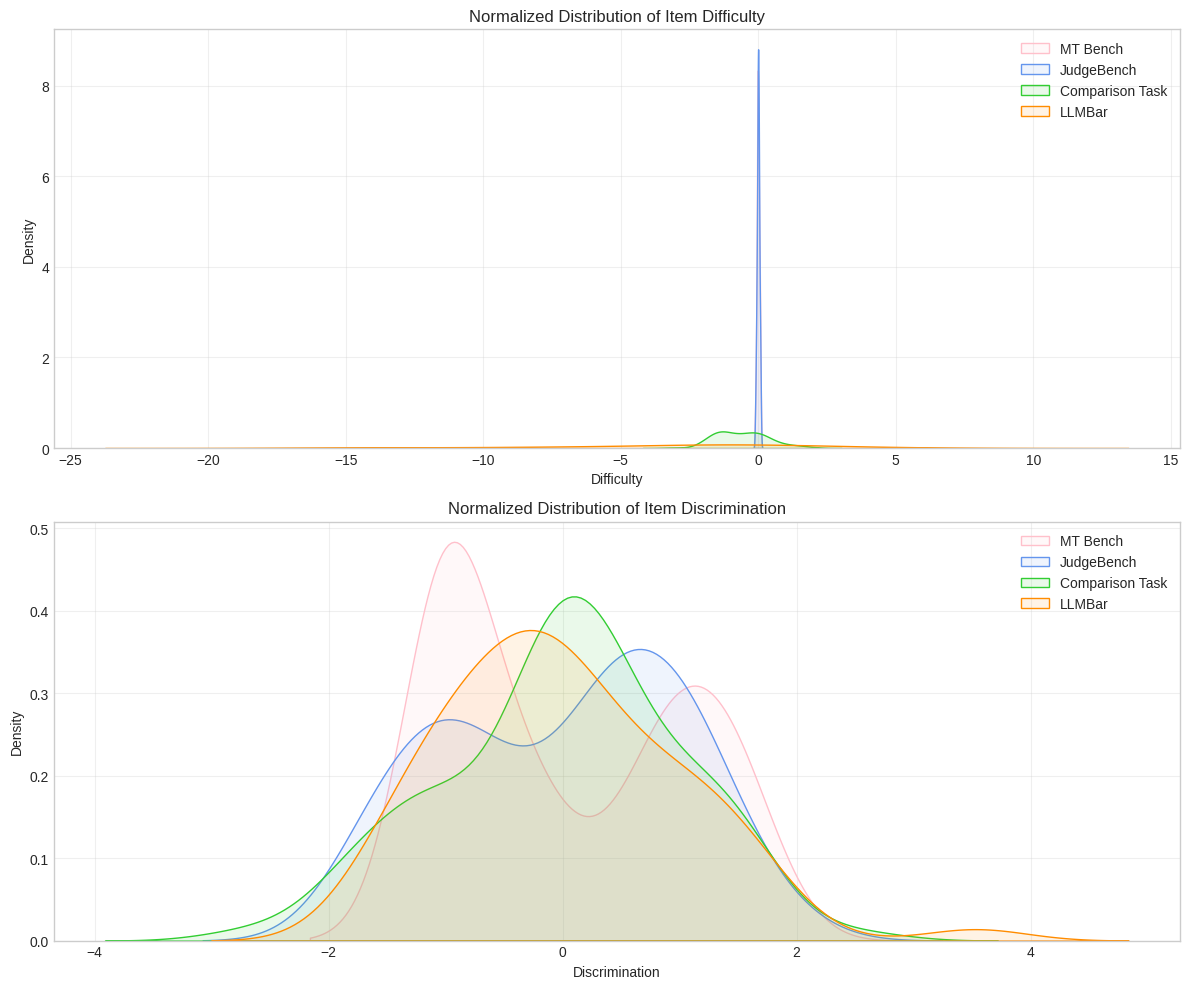

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

data_dict = all_items.copy()

# Alternative using Seaborn for more attractive plots
plt.figure(figsize=(12, 10))

custom_colors = {
    'MT Bench': 'pink',    # Purple
    'LLMBar': 'darkorange',     # Teal
    'JudgeBench': 'cornflowerblue', # Light green
    'Comparison Task': 'limegreen'        # Blue
}

# First subplot for 'diff'
plt.subplot(2, 1, 1)
for name, df in data_dict.items():
    # KDE plot with density normalized
    # sns.kdeplot(df['diff'], label=name, fill=True, alpha=0.3, common_norm=True)
    sns.kdeplot(stats.zscore(df['diff']), label = name, fill = True, alpha = 0.1, color = custom_colors.get(name, None))

plt.title('Normalized Distribution of Item Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Second subplot for 'disc'
plt.subplot(2, 1, 2)
for name, df in data_dict.items():
    # KDE plot with density normalized
    # sns.kdeplot(df['disc'], label=name, fill=True, alpha=0.3, common_norm=True)
    sns.kdeplot(stats.zscore(df['disc']), label=name, fill=True, alpha=0.1, common_norm=True, color = custom_colors.get(name, None))

plt.title('Normalized Distribution of Item Discrimination')
plt.xlabel('Discrimination')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('item_difficulty_discrimination.png', dpi=300)
plt.show()

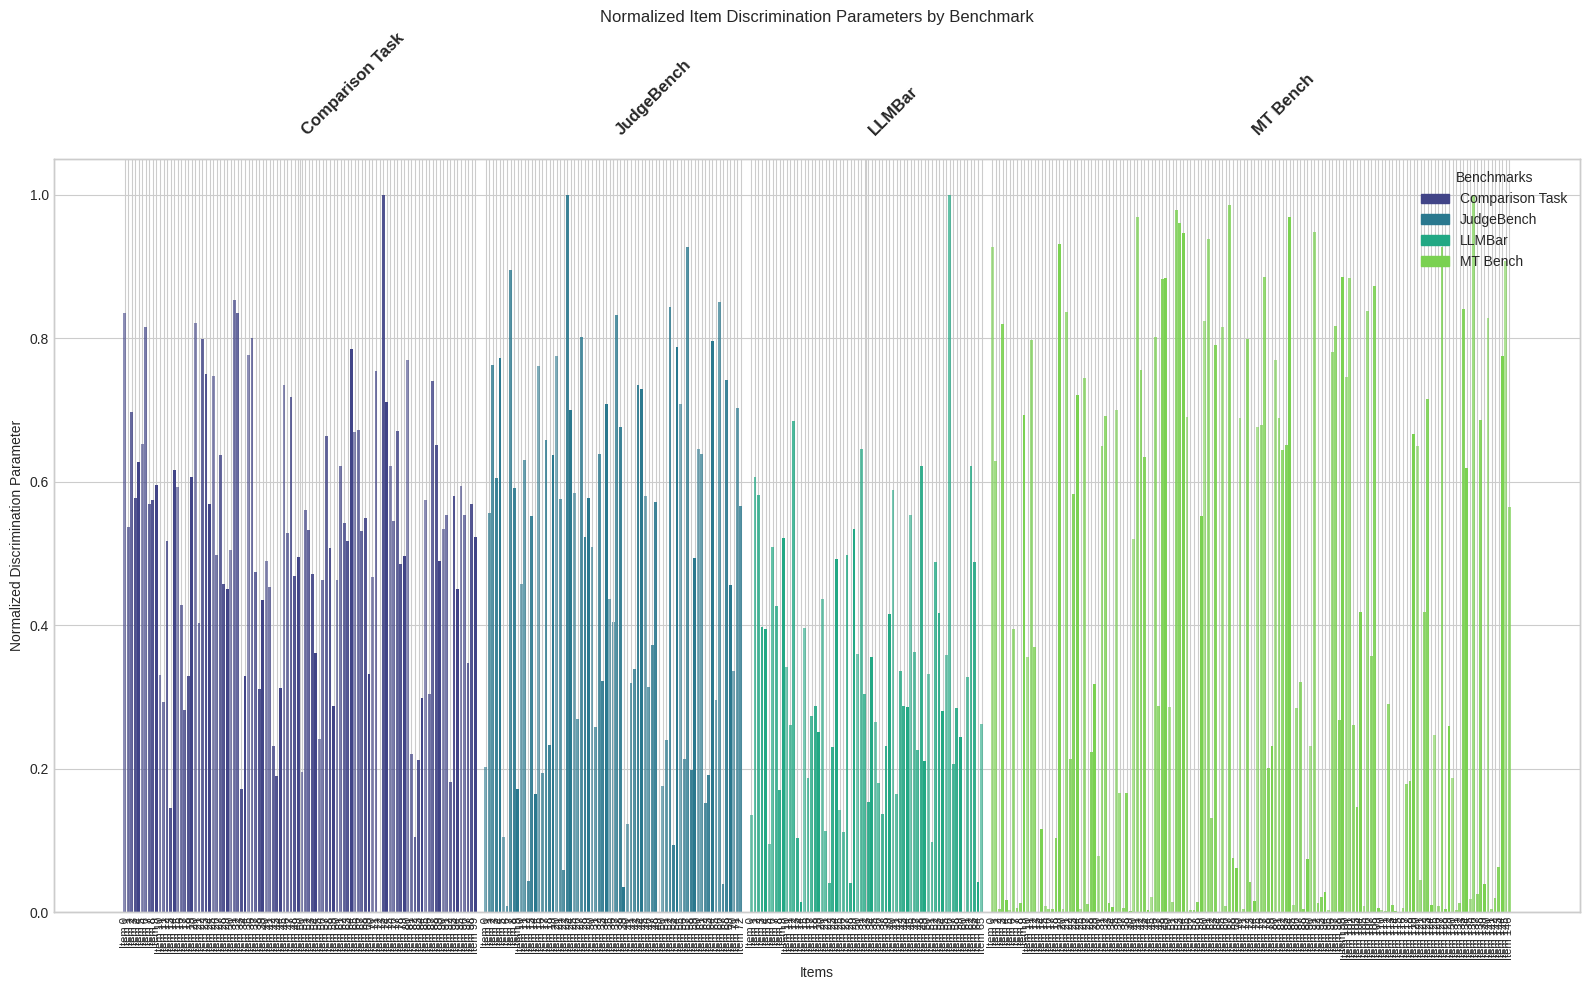

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Function to visualize the data
def visualize_benchmarks(benchmark_dict):
    # Prepare data for plotting
    all_data = []

    # Process each benchmark and its items
    for benchmark_name, df in benchmark_dict.items():
        # Normalize discrimination values for this benchmark
        min_disc = df['disc'].min()
        max_disc = df['disc'].max()

        # Prevent division by zero if all values are the same
        if max_disc == min_disc:
            normalized_disc = [1.0] * len(df)
        else:
            normalized_disc = (df['disc'] - min_disc) / (max_disc - min_disc)

        # For each item (row) in the benchmark's dataframe
        for idx, (_, row) in enumerate(df.iterrows()):
            all_data.append({
                'benchmark': benchmark_name,
                'item_id': f"{benchmark_name}_{idx}",
                'disc': row['disc'],  # Original discrimination parameter
                'norm_disc': normalized_disc.iloc[idx]  # Normalized value (0-1)
            })

    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame(all_data)

    # Sort by benchmark for better visualization
    plot_df = plot_df.sort_values('benchmark')

    # Get unique benchmarks and create a color palette
    unique_benchmarks = plot_df['benchmark'].unique()
    palette = sns.color_palette("viridis", len(unique_benchmarks))
    benchmark_colors = {bench: palette[i] for i, bench in enumerate(unique_benchmarks)}

    # Create the figure and axis
    plt.figure(figsize=(16, 10))

    # Prepare for plotting
    bar_width = 0.8

    # Plot each benchmark
    current_pos = 0
    tick_positions = []
    tick_labels = []
    benchmark_positions = []
    benchmark_labels = []

    for i, benchmark in enumerate(unique_benchmarks):
        # Get items for this benchmark
        bench_df = plot_df[plot_df['benchmark'] == benchmark]
        num_items = len(bench_df)

        # Calculate positions for this benchmark's items
        positions = np.arange(current_pos, current_pos + num_items)
        tick_positions.extend(positions)
        tick_labels.extend([f"Item {idx}" for idx in range(len(positions))])

        # Record the middle position for benchmark label
        benchmark_positions.append(current_pos + num_items/2 - 0.5)
        benchmark_labels.append(benchmark)

        # Create bars with different shades
        base_color = benchmark_colors[benchmark]
        for j, (_, row) in enumerate(bench_df.iterrows()):
            # Vary the shade/alpha for different items
            alpha = 0.6 + (j % 5) * 0.1  # Cycle through 5 different shades
            plt.bar(positions[j], row['norm_disc'], width=bar_width,
                   color=base_color, alpha=alpha)

        # Add a gap after each benchmark group
        current_pos += num_items + 2

    # Add labels, title
    plt.xlabel('Items')
    plt.ylabel('Normalized Discrimination Parameter')
    plt.title('Normalized Item Discrimination Parameters by Benchmark')

    # Set x-ticks for items
    plt.xticks(tick_positions, tick_labels, rotation=90, ha='center', fontsize=8)

    # Add benchmark labels on a second level
    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(benchmark_positions)
    ax2.set_xticklabels(benchmark_labels, rotation=45, ha='left', fontsize=12, fontweight='bold')
    ax2.tick_params(pad=15)

    # Add a legend for benchmarks
    handles = [plt.Rectangle((0,0),1,1, color=benchmark_colors[bench]) for bench in unique_benchmarks]
    plt.legend(handles, unique_benchmarks, title="Benchmarks", loc="upper right")

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    return plt

# Example usage:
benchmark_dict = all_items.copy()
plt = visualize_benchmarks(benchmark_dict)
plt.savefig('benchmark_visualization.png', dpi=300)
plt.show()

# For Google Colab, you need to call this at the end:
# visualize_benchmarks(benchmark_dict)

In [ ]:
thetas = pd.read_csv(
  '/content/drive/MyDrive/senior_thesis/irt/final_combined_thetas.csv')
thetas.head()
df = thetas.copy()
df['Model_Family'] = df['Model'].apply(get_model_family)
df.head()

,Model,IFEval,Parameters,LLMBar,MT Bench,JudgeBench,Comparison Task,Model_Family
0,gpt2-small,17.93,"137,000,000",NaN,NaN,NaN,-1.313103,gpt2
1,gpt2-large,20.48,"812,000,000",NaN,NaN,NaN,-0.843485,gpt2
2,llama-3.2-3b,13.37,"3,210,000,000",NaN,NaN,NaN,-1.006175,llama
3,llama-3.2-1b-it,56.98,"1,240,000,000",-0.055270,2.197716,0.118551,-0.550444,llama
4,llama-3.2-3b-it,73.93,"3,210,000,000",1.228031,2.477594,-0.104923,0.456605,llama


In [ ]:
custom_colors = {
    'MT Bench': 'pink',    # Purple
    'LLMBar': 'darkorange',     # Teal
    'JudgeBench': 'cornflowerblue', # Light green
    'Comparison Task': 'limegreen'        # Blue
}

In [ ]:
def generate_wright_map_dashboard(df, benchmark_params, save_path=None, max_cols=2):
    """
    Generate a dashboard of Wright maps for all benchmarks with Seaborn-style density plots.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright maps. If None, displays the plots instead.
    max_cols : int
        Maximum number of columns in the dashboard
    """
    # Get all benchmark names
    benchmark_names = [col for col in df.columns if col in benchmark_params]
    n_benchmarks = len(benchmark_names)

    # Calculate grid dimensions
    n_cols = min(max_cols, n_benchmarks)
    n_rows = (n_benchmarks + n_cols - 1) // n_cols

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create figure
    fig = plt.figure(figsize=(7 * n_cols, 6 * n_rows))

    for i, benchmark in enumerate(benchmark_names):
        print(f"Adding {benchmark} to dashboard...")

        # Get item parameters for this benchmark
        item_params = benchmark_params[benchmark]

        # Create subplot for this benchmark
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # Get valid theta values (not NaN)
        thetas = df[benchmark].dropna().values

        # Sort items by difficulty
        sorted_items = item_params.sort_values('diff')
        item_y = sorted_items['diff'].values

        # Calculate common y-range
        y_min = min(min(thetas), min(item_y)) - 0.5
        y_max = max(max(thetas), max(item_y)) + 0.5

        # Use Seaborn's kdeplot for the density plot
        sns.kdeplot(y=thetas, ax=ax, fill=True, color=custom_colors.get(benchmark, None), alpha=0.6,
                   bw_adjust=0.8, label='Model Abilities')

        # Calculate x position for item points (at the right edge of density plot)
        x_pos = ax.get_xlim()[1] * 0.8

        # Plot item difficulties as points
        ax.scatter([x_pos] * len(item_y), item_y, color='tomato',
                  alpha=0.7, s=50, zorder=5, label='Item Difficulties')

        # Add a legend with proper styling
        ax.legend(loc='upper right', frameon=True, framealpha=0.9)

        # Set title and labels with Seaborn-style fonts
        ax.set_title(f'Wright Map: {benchmark}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Density', fontsize=11)
        ax.set_ylabel('Ability / Difficulty Scale', fontsize=11)

        # Set y-axis limits
        ax.set_ylim(y_min, y_max)

        # Add reference lines at standard deviations
        for sd in [-2, -1, 0, 1, 2]:
            ax.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)
            ax.text(ax.get_xlim()[0] * 0.9, sd, f"SD {sd}",
                   fontsize=8, va='center', ha='left', alpha=0.7)

        # Add x-axis at bottom only
        ax.spines['bottom'].set_visible(True)

        # Add light grid
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()

    plt.savefig(f"{save_path}/wright_map_dashboard.png", dpi=300, bbox_inches='tight')

    plt.show()

    plt.close()


In [ ]:
generate_wright_map_dashboard(df, all_items, save_path='/content/')

##item figs -- bench



In [ ]:
bench_truth = pd.read_csv('/content/drive/MyDrive/senior_thesis/MT_Bench/mtbench_ground_truth.csv')
bench_truth.head()

,Unnamed: 0,input,output_1,output_2,label,id
0,0,Explain what's base rate fallacy and list five...,"Base rate fallacy, also known as base rate neg...",Base rate fallacy is a cognitive bias that occ...,1,0
1,1,"x+y = 4z, x*y = 4z^2, express x-y in z",x-y = -2z,We can start by using the formula for (x+y)^2:...,2,1
2,2,Please describe the concept of machine learnin...,Machine learning is a subfield of artificial i...,Machine learning is a type of artificial intel...,1,2
3,3,Suggest five award-winning documentary films w...,Here are five award-winning documentary films ...,1. The Cove (2009): This Academy Award-winning...,1,3
4,4,Benjamin went to a bookstore and purchased a v...,The cost of 5 copies of the sci-fi novel is 5 ...,* 5 sci-fi novels at $20 each = 5 * $20 = $100...,2,4


In [ ]:
bench = all_items['MT Bench']
disc_bench = bench.sort_values(by='disc', ascending = False)
diff_bench = bench.sort_values(by='diff', ascending = False)


In [ ]:
disc_bench.head()

In [ ]:
bench_truth[bench_truth['id'] == 139]


In [ ]:
disc_bench.tail()

In [ ]:
bench_truth[bench_truth['id'] == 148]


In [ ]:
diff_bench.head()

In [ ]:
bench_truth[bench_truth['id'] == 160]


In [ ]:
# bench_truth[bench_truth['id'] == 161]

In [ ]:
diff_bench.tail()

In [ ]:
bench_truth[bench_truth['id'] == 128]


## item fig analysis??

In [ ]:
all_items

{'MT Bench':      Unnamed: 0      diff      disc   id
 0             0 -0.042780  0.123390    2
 1             1 -0.039072  0.003989    4
 2             2 -0.019680  0.062920    6
 3             3 -0.033185  0.192624    7
 4             4  0.001153  0.192318    8
 ..          ...       ...       ...  ...
 142         142  0.011025  0.170361  193
 143         143 -0.008905  0.001344  194
 144         144  0.018269  0.006886  196
 145         145 -0.020505  0.005494  197
 146         146  0.063647  0.152638  198
 
 [147 rows x 4 columns],
 'JudgeBench':     Unnamed: 0      diff      disc                                    id
 0            0 -0.025544  0.011609  8e1df938-fb37-5c27-8a0d-aedee854251a
 1            1  0.038084  0.012287  c0b98b73-d73d-5bfd-a34f-59d68457e992
 2            2 -0.038900  0.022522  b0446013-eece-5acc-bbfa-9145f5a61ed1
 3            3  0.076386  0.014044  575b2175-e75b-5f1a-ba75-8fa7a1e44f90
 4            4  0.013359  0.020946  c42511bf-0b43-5395-8a2b-f8748c6afdbf

In [ ]:
llmbar_truth = pd.read_csv('/content/drive/MyDrive/senior_thesis/llm_bar/llmbar_ground_truth.csv')
llmbar_truth.head()

,id,input,output_1,output_2,label
0,0,Summarize the following content.\n\nMy girlfri...,My girlfriend's visa to stay in the UK expires...,My girlfriend is Malaysian and has been studyi...,1
1,1,Complete a brief story given the following fir...,He learned his weather report. He prepared for...,He would always mistreat it every day. He eats...,1
2,2,How many integers are in the solution of the i...,The inequality |x + 5| < 10 means that the abs...,The list of integers that satisfy the inequali...,1
3,3,Why does eating something crunchy sound so lou...,The sound is transmitted through the vibration...,The noise that crunchy foods make when we eat ...,1
4,4,Summarize the following content.\n\nMy bf only...,Boyfriend only likes to talk through text. He ...,My boyfriend only likes to text me for shallow...,2


In [ ]:
judgebench_truth = pd.read_csv('/content/drive/MyDrive/senior_thesis/judgebench/judgebench_ground_truth.csv')
judgebench_truth.head()

,Unnamed: 0,id,original_id,source,question,response_model,response_A,response_B,label
0,0,b5ce1305-50fe-5a5e-b785-325ab15c6d2b,6603.0,mmlu-pro-health,"In the brain stem, pathways for:\n(A) discrimi...",claude-3-5-sonnet-20240620,Let's break this down step by step:\n\n1. The ...,Let's think through this step-by-step:\n\n1) T...,A
1,1,8e1df938-fb37-5c27-8a0d-aedee854251a,6275.0,mmlu-pro-health,The best available evidence for an association...,claude-3-5-sonnet-20240620,Let's think through this step-by-step:\n\n1. D...,Let's think through this step-by-step:\n\n1) D...,B
2,2,cba66923-b65f-566a-a766-03039fe2345c,6643.0,mmlu-pro-health,What is the most common way for a virus to kil...,claude-3-5-sonnet-20240620,Let's think through this step-by-step:\n\n1) V...,Let's approach this step-by-step:\n\n1) Viruse...,B
3,3,40a0f1d8-fbfe-53e3-947f-3ead7276284e,6446.0,mmlu-pro-health,A 19-year-old woman comes to the emergency dep...,claude-3-5-sonnet-20240620,Let's approach this step-by-step:\n\n1. The pa...,Let's analyze this scenario step-by-step:\n\n1...,A
4,4,bdad5388-27d0-5001-a4ba-cb2208edf775,6573.0,mmlu-pro-health,Which of the following best explains the antio...,claude-3-5-sonnet-20240620,Let's analyze each option:\n\n1) Vitamin E is ...,Let's analyze each option and think through th...,A


In [ ]:
comp_truth = pd.read_csv('/content/drive/MyDrive/senior_thesis/comparison_essay_grading/paired_essays/overall_paired_essays.csv')
comp_truth['id'] = comp_truth['id_1']+comp_truth['id_2']
comp_truth.head()

,id_1,id_2,text_1,text_2,1_better,prompt,id
0,EBAC7604E958,ACDF0CAAF77C,"Dear Principal,\n\nPrincipal I will suggest po...",Dear TEACHER_NAME\n\nI've realized you have be...,0,Cell phones at school,EBAC7604E958ACDF0CAAF77C
1,4FE8CD4987B6,F7B655834981,I think policy one is good because at lunch st...,she is not to bring a phones in school because...,1,Cell phones at school,4FE8CD4987B6F7B655834981
2,4210C4CA9806,CEC71375C061,"Dear Principal,\n\nI think you should let us b...",Policy1: I think we should be allowed to use o...,1,Cell phones at school,4210C4CA9806CEC71375C061
3,223FCA37F79D,1B2B4A98C5E6,We should allow the students to bring there ce...,Policy 2: Do not allow students to have phones...,1,Cell phones at school,223FCA37F79D1B2B4A98C5E6
4,1D51BCF69AD3,3AB3FC197550,"dear principal,\n\ni think all students should...",Do you really think students need cell phones ...,0,Cell phones at school,1D51BCF69AD33AB3FC197550


In [ ]:
all_items['Comparison Task']['id'] = all_items['Comparison Task']['id_1']+all_items['Comparison Task']['id_2']
all_items['Comparison Task'].head()

,Unnamed: 0,diff,disc,id_1,id_2,id
0,0,-0.233765,0.209352,A828480AA508,AA8DA5629CBC,A828480AA508AA8DA5629CBC
1,1,-0.557398,0.251150,65B7FDE783F2,1732E7BCD28D,65B7FDE783F21732E7BCD28D
2,2,-0.476900,0.230712,7DC02C918305,98BD2D5840A1,7DC02C91830598BD2D5840A1
3,3,-1.033011,0.249490,6060D28C05B6,5AC16E188F1B,6060D28C05B65AC16E188F1B
4,4,0.753953,0.224843,3F3DC123EDF6,CBFD5CD8BCD9,3F3DC123EDF6CBFD5CD8BCD9


In [ ]:
def get_item_stats(items, ground_truth, num = 10, id_col='id'):
    # Sort items by difficulty and discrimination
    disc = items.sort_values(by='disc', ascending=False)
    diff = items.sort_values(by='diff', ascending=False)

    # Get the most and least difficult/discriminating items
    most_diff = diff[:num]
    least_diff = diff[-num:]
    most_disc = disc[:num]
    least_disc = disc[-num:]

    # Create dataframes instead of lists
    difficult = ground_truth[ground_truth[id_col].isin(most_diff['id'])]
    easy = ground_truth[ground_truth[id_col].isin(least_diff['id'])]
    discriminable = ground_truth[ground_truth[id_col].isin(most_disc['id'])]
    non_discriminable = ground_truth[ground_truth[id_col].isin(least_disc['id'])]

    return difficult, easy, discriminable, non_discriminable

In [ ]:
all_difficult = []
all_easy = []
all_discriminable = []
all_non_discriminable = []

def add_stats(difficult, easy, discriminable, non_discriminable):
  all_difficult.append(difficult)
  all_easy.append(easy)
  all_discriminable.append(discriminable)
  all_non_discriminable.append(non_discriminable)

def get_difference(col1, col2, df):

  return abs(df[col1].str.split().str.len() - df[col2].str.split().str.len()).mean()

difficult, easy, discriminable, non_discriminable = get_item_stats(all_items['MT Bench'], bench_truth)
#avg length diff of output 1 and 2 for each one
print("MT Bench")
print(discriminable.head())





MT Bench
    Unnamed: 0                                              input  \
16          16  Embody the persona of Tony Stark from “Iron Ma...   
23          23  Analyze the following customer reviews from di...   
24          24  How do the stages of life shape our understand...   
34          34  Craft an intriguing opening paragraph for a fi...   
44          44  Identify the named entities (people, organizat...   

                                             output_1  \
16  Well, Pepper, it's certainly not the constant ...   
23  {\n  "iPhone": 8.5,\n  "Samsung Galaxy": 8.3,\...   
24  The stages of life shape our understanding of ...   
34  Here is a possible opening paragraph for that ...   
44  {\n"organizations": [\n"Faraday",\n"Daimler AG...   

                                             output_2  label  id  
16  As Stark, my favorite part about being Iron Ma...      1  16  
23       {"iPhone": 8.5, "Galaxy": 8.3, "Pixel": 8.1}      1  23  
24  The stages of life can shape

In [ ]:


difficult, easy, discriminable, non_discriminable = get_item_stats(all_items['Comparison Task'], comp_truth)
print("Comparison Task")
print(get_difference('text_1', 'text_2', difficult))
print(get_difference('text_1', 'text_2', easy))
print(get_difference('text_1', 'text_2', discriminable))
print(get_difference('text_1', 'text_2', non_discriminable))


Comparison Task
243.6
229.9
193.5
249.4


In [ ]:

difficult, easy, discriminable, non_discriminable = get_item_stats(all_items['JudgeBench'], judgebench_truth)
print("JudgeBench")
print(get_difference('response_A', 'response_B', difficult))
print(get_difference('response_A', 'response_B', easy))
print(get_difference('response_A', 'response_B', discriminable))
print(get_difference('response_A', 'response_B', non_discriminable))


JudgeBench
21.0
31.4
21.0
24.0


In [ ]:

difficult, easy, discriminable, non_discriminable = get_item_stats(all_items['LLMBar'], llmbar_truth)
print("LLMBar")
print(get_difference('output_1', 'output_2', difficult))
print(get_difference('output_1', 'output_2', easy))
print(get_difference('output_1', 'output_2', discriminable))
print(get_difference('output_1', 'output_2', non_discriminable))

LLMBar
55.1
20.2
20.4
52.5


In [ ]:
all_items['JudgeBench'].head()
judgebench_item_df = all_items['JudgeBench'].merge(judgebench_truth, on='id')
judgebench_item_df.head()

In [ ]:
df = judgebench_item_df.copy()
df.head()

In [ ]:
df = all_items['Comparison Task'].merge(comp_truth, on='id')
df.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
# Function to create plots with similar style to the image, handling negative values
def create_discrimination_plot(df, value_column, title_suffix):
    plt.figure(figsize=(12, 8))

    # Compute mean value per source (prompt), and sort by it
    prompt_means = df.groupby('prompt')[value_column].mean().sort_values()
    sorted_sources = prompt_means.index.tolist()

    # Create color palette and map
    colors = sns.color_palette("husl", len(sorted_sources))
    color_map = dict(zip(sorted_sources, colors))

    min_value = min(0, df[value_column].min() - 0.2)
    max_value = df[value_column].max() + 0.5

    all_positions = []
    start_position = 0
    source_positions = {}

    for i, source in enumerate(sorted_sources):
        source_data = df[df['prompt'] == source]

        # Optional: sort items within a prompt by difficulty/discrimination
        # source_data = source_data.sort_values(by=value_column)

        positions = np.arange(start_position, start_position + len(source_data))
        source_positions[source] = positions
        all_positions.extend(positions)

        plt.bar(positions, source_data[value_column],
                color=[color_map[source]] * len(source_data),
                width=0.8)

        start_position = positions[-1] + 2

    threshold = 2.0
    if min_value < threshold < max_value:
        plt.axhline(y=threshold, color='black', linestyle='--', alpha=0.7)
        plt.text(all_positions[-1], threshold + 0.05, 'High discrimination threshold', ha='right')

    plt.ylim(min_value, max_value)
    plt.ylabel(f'{value_column.capitalize()} Parameter (a)')

    if min_value < 0:
        plt.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)

    plt.xlabel('Items by Source')
    plt.xticks([])

    for source, positions in source_positions.items():
        mid_position = np.mean(positions)
        plt.text(mid_position, min_value - 0.15 * (max_value - min_value),
                 source, ha='center', fontsize=12,
                 transform=plt.gca().transData)

    legend_elements = [Patch(facecolor=color_map[source], label=source)
                      for source in sorted_sources]
    plt.legend(handles=legend_elements, title='Source Categories',
               loc='upper right', bbox_to_anchor=(1, 1),
               frameon=True, fontsize=10)

    plt.title(f'{value_column.capitalize()} Parameters by Source Item\nHigher values indicate items that better differentiate model abilities',
              fontsize=14)

    plt.tight_layout()
    return plt



# Create plots
disc_plot = create_discrimination_plot(df, 'disc', 'Discrimination')
disc_plot.savefig('discrimination_plot.png')
disc_plot.show()

diff_plot = create_discrimination_plot(df, 'diff', 'Difficulty')
diff_plot.savefig('difficulty_plot.png')
diff_plot.show()

In [ ]:
def create_mean_plot(df, value_column, value_description):
    plt.figure(figsize=(12, 5))  # Made the figure even shorter (height reduced to 5)

    # Calculate means for each source
    mean_data = df.groupby('source')[value_column].mean().reset_index()

    # Sort by mean value (optional)
    mean_data = mean_data.sort_values(by=value_column)

    # Get unique sources in the sorted order
    sources = mean_data['source'].tolist()

    # Create color palette - using distinct colors for each source
    colors = sns.color_palette("husl", len(sources))
    color_map = dict(zip(sources, colors))

    # Calculate appropriate y-axis range for each parameter (tighter range)
    min_value = max(0, mean_data[value_column].min() - (mean_data[value_column].max() - mean_data[value_column].min()) * 0.6)
    max_value = mean_data[value_column].max() + (mean_data[value_column].max() - mean_data[value_column].min()) * 0.6

    # Handle case of negative values
    if mean_data[value_column].min() < 0:
        min_value = mean_data[value_column].min() - (mean_data[value_column].max() - mean_data[value_column].min()) * 0.6

    # Create positions with increased spacing
    positions = np.arange(len(sources)) * 1.5  # Increase spacing between bars

    for i, source in enumerate(sources):
        source_mean = mean_data[mean_data['source'] == source][value_column].values[0]
        plt.bar(positions[i], source_mean, color=color_map[source], width=0.8)

        # Add value label above each bar with more significant figures
        plt.text(positions[i], source_mean + (max_value - min_value) * 0.02,
                f'{source_mean:.4f}', ha='center', va='bottom', fontsize=10)

    # Add appropriate threshold line based on the parameter (if applicable)
    if value_column == 'disc':
        threshold = 0.05  # Threshold for discrimination
    else:
        threshold = 2.0  # Threshold for difficulty

    threshold_label = "High discrimination threshold" if value_column == "disc" else "High difficulty threshold"

    if min_value < threshold < max_value:
        plt.axhline(y=threshold, color='black', linestyle='--', alpha=0.7)
        plt.text(positions[-1] + 0.3, threshold + (max_value - min_value) * 0.02,
                threshold_label, ha='right')

    # Set y-axis with tighter scaling
    plt.ylim(min_value, max_value)

    # Format y-axis ticks with more precision for both parameters
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

    # Set appropriate y-axis label based on parameter
    if value_column == "disc":
        plt.ylabel('Mean Discrimination Parameter (a)')
        subtitle = "Higher values indicate sources that better differentiate model abilities"
    else:  # diff
        plt.ylabel('Mean Difficulty Parameter (b)')
        subtitle = "Higher values indicate sources with more challenging items"

    # Add a zero line if we have negative values
    if min_value < 0:
        plt.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)

    # Set x-axis with enough space for labels
    plt.xlabel('Source')
    plt.xticks(positions, sources, rotation=30, ha='right')  # Rotate labels to avoid overlap

    # Set title and subtitle
    plt.title(f'Mean {value_description} Parameters by Source\n{subtitle}',
              fontsize=14)

    # Add error bars (standard deviation)
    error_data = df.groupby('source')[value_column].std().reset_index()
    error_values = []
    for source in sources:
        error_values.append(error_data[error_data['source'] == source][value_column].values[0])

    plt.errorbar(positions, mean_data[value_column], yerr=error_values, fmt='none',
                 ecolor='black', capsize=5, elinewidth=1, capthick=1)

    plt.tight_layout()
    return plt

# Create plots with correct descriptions
disc_plot = create_mean_plot(df, 'disc', 'Discrimination')
disc_plot.xlabel('')
disc_plot.savefig('mean_discrimination_plot.png')
disc_plot.show()

diff_plot = create_mean_plot(df, 'diff', 'Difficulty')
diff_plot.savefig('mean_difficulty_plot.png')
diff_plot.show()

In [ ]:

from google.colab import files

for file in os.listdir():
  if file.endswith('.png'):
    files.download(file)


## ahhh

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

In [ ]:
accuracies = pd.read_csv('/content/drive/MyDrive/senior_thesis/irt/combined_accuracies.csv')
accuracies.head()

In [ ]:
thetas = pd.read_csv('/content/drive/MyDrive/senior_thesis/irt/final_combined_thetas.csv')
thetas.head()

In [ ]:
df = thetas.merge(accuracies, on='Model', suffixes=('_theta', '_accuracy'))
df.head()

In [ ]:
# prompt: Using dataframe df: give me a dataframe showing the correlation between each benchmark's theta and accuracy

import pandas as pd

# Create a list to store the correlation data
correlations = []

# Define the benchmark columns and accuracy columns
benchmark_theta_cols = ['Comparison Task_theta', 'MT Bench_theta', 'LLMBar_theta', 'JudgeBench_theta']
benchmark_accuracy_cols = ['Comparison Task_accuracy', 'MT Bench_accuracy', 'LLMBar_accuracy', 'JudgeBench_accuracy']


# Iterate over the benchmark columns
for i in range(len(benchmark_theta_cols)):
    # Calculate the correlation between the benchmark's theta and accuracy
    theta_col = benchmark_theta_cols[i]
    accuracy_col = benchmark_accuracy_cols[i]

    correlation = df[theta_col].corr(df[accuracy_col])

    # Append the correlation data to the list
    correlations.append({
        'Benchmark': theta_col.replace("_theta", ""),  # Extract the benchmark name
        'Correlation': correlation
    })

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlations)

# Display the DataFrame
correlation_df


In [4]:
llmbar = pd.read_csv('/content/llmbar.csv')
judgebench = pd.read_csv('/content/judgebench.csv')


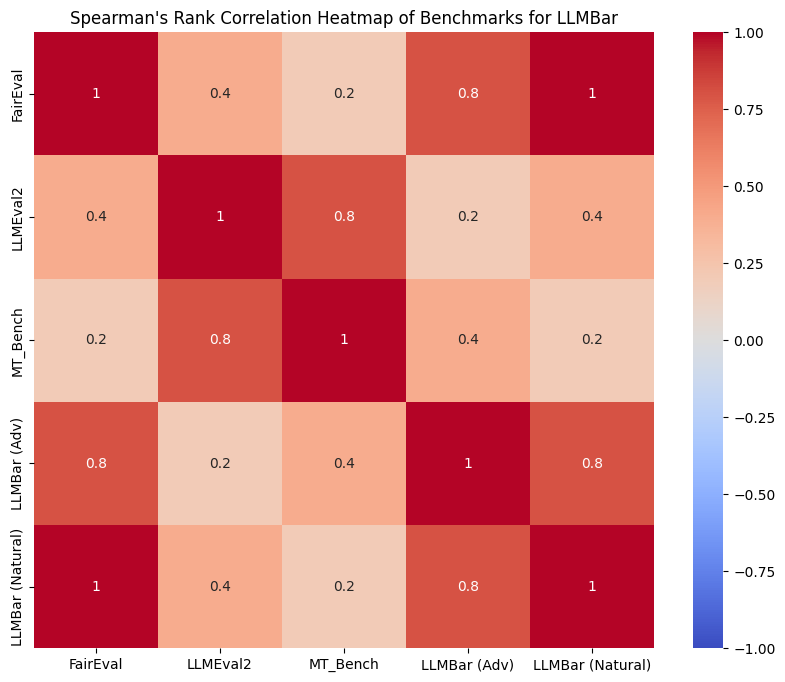

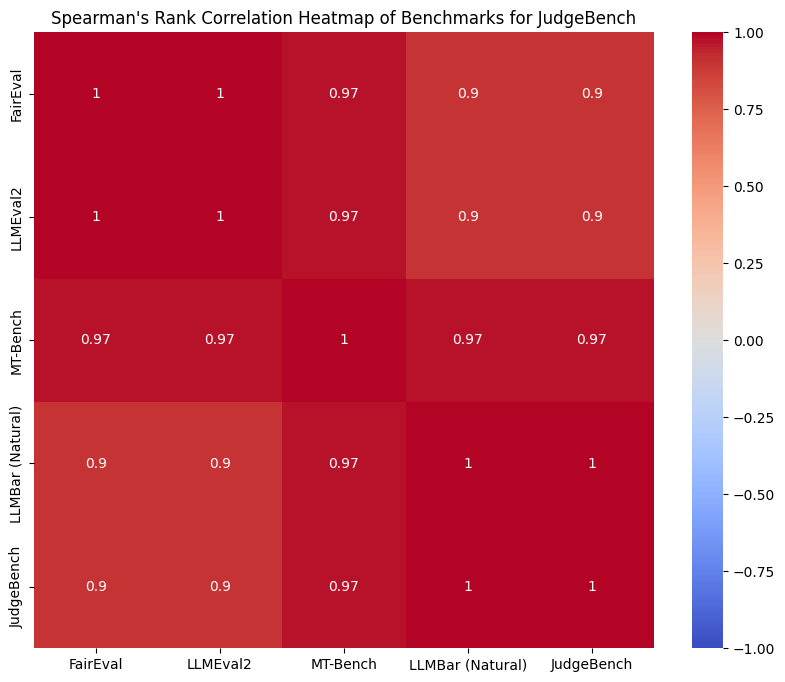

In [7]:
# prompt: define a function : for each column that is not "Model", that is a benchmark column. Do spearman's correlation heatmap between the benchmarks. run it with llmbar and judgebench

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def benchmark_correlation_heatmap(df, benchmark_names, name):
  """
  Calculates and visualizes the Spearman's rank correlation between benchmark columns.

  Args:
    df: Pandas DataFrame containing the benchmark data.
    benchmark_names: A list of column names representing the benchmarks.
  """
  # Subset the DataFrame to include only the specified benchmark columns
  benchmark_df = df[benchmark_names]

  # Calculate the Spearman's rank correlation matrix
  correlation_matrix, _ = spearmanr(benchmark_df, axis=0)

  # Create a heatmap of the correlation matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
              xticklabels=benchmark_names, yticklabels=benchmark_names,
              vmin=-1, vmax=1)
  plt.title(f"Spearman's Rank Correlation Heatmap of Benchmarks for {name}")
  plt.show()

llmbar_benchmarks = ['FairEval'	,'LLMEval2','MT_Bench'	,'LLMBar (Adv)'	,'LLMBar (Natural)']
judgebench_benchmarks = ['FairEval'	,'LLMEval2'	,'MT-Bench'	,'LLMBar (Natural)',	'JudgeBench']
benchmark_correlation_heatmap(llmbar, llmbar_benchmarks, "LLMBar")
benchmark_correlation_heatmap(judgebench, judgebench_benchmarks, "JudgeBench")


## depreciated


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# import matplotlib.gridspec as gridspec

# # Assuming df has 'Model_Family' column and benchmark columns
# # Get unique model families
# model_families = df['Model_Family'].unique()

# # Get benchmark columns (all columns except 'Model' and 'Model_Family')
# benchmark_cols = sorted([col for col in df.columns if col not in ['Model', 'Model_Family', 'Parameters']])

# # Create a figure with subplots for each model family
# n_families = len(model_families)
# fig = plt.figure(figsize=(15, n_families * 6))
# gs = gridspec.GridSpec(n_families, 1, height_ratios=[1] * n_families)

# # Create a heatmap for each model family
# for i, family in enumerate(model_families):
#     # Filter data for this model family
#     family_data = df[df['Model_Family'] == family]

#     # Skip if less than 3 models in the family (can't compute meaningful correlations)
#     if len(family_data) < 3:
#         print(f"Skipping {family} - only {len(family_data)} models (need at least 3 for correlation)")
#         continue

#     # Calculate Spearman correlation for this family
#     corr = family_data[benchmark_cols].corr(method='spearman')

#     # Calculate p-values for Spearman correlation
#     def calculate_spearman_pvalues(df):
#         df_cols = df.columns.tolist()
#         n = len(df_cols)
#         pvalues = np.ones((n, n))  # Initialize with ones (p=1)

#         for i, col1 in enumerate(df_cols):
#             for j, col2 in enumerate(df_cols):
#                 if i != j:  # Skip diagonal
#                     try:
#                         # Use Spearman correlation
#                         stat, p = stats.spearmanr(df[col1], df[col2])
#                         pvalues[i, j] = p
#                     except Exception as e:
#                         print(f"Error calculating p-value for {col1} and {col2} in {family}: {str(e)}")
#                         pvalues[i, j] = 1.0  # Default to no significance
#                 else:
#                     pvalues[i, j] = 1.0  # p-value for self correlation is 1

#         return pd.DataFrame(pvalues, index=df_cols, columns=df_cols)

#     # Calculate p-values
#     p_values = calculate_spearman_pvalues(family_data[benchmark_cols])

#     # Create subplot
#     ax = plt.subplot(gs[i])

#     # Create the heatmap
#     heatmap = sns.heatmap(corr,
#                           annot=True,
#                           cmap='coolwarm',
#                           vmin=-1, vmax=1,
#                           fmt='.2f',
#                           linewidths=0.5,
#                           ax=ax)

#     # Add p-value annotations
#     # for i in range(len(corr.columns)):
#     #     for j in range(len(corr.columns)):
#     #         if i != j:  # Skip the diagonal
#     #             # Check significance level
#     #             if p_values.iloc[i, j] <= 0.05:
#     #                 # Add asterisks for significance
#     #                 if p_values.iloc[i, j] <= 0.001:
#     #                     sig = '***'
#     #                 elif p_values.iloc[i, j] <= 0.01:
#     #                     sig = '**'
#     #                 else:
#     #                     sig = '*'

#     #                 # Get coordinates of the cell
#     #                 x = j
#     #                 y = i

#     #                 # Add significance markers
#     #                 text = heatmap.axes.text(x + 0.5, y + 0.85, sig,
#     #                                          ha="center", va="baseline",
#     #                                          color="black", fontweight='bold')

#     # Set title for this subplot
#     ax.set_title(f'Spearman Correlation Heatmap for {family} Models (n={len(family_data)})')

# # Adjust layout
# plt.tight_layout()

# # Add a legend for significance levels at the bottom of the full figure
# # fig.text(0.01, 0.01, "* p≤0.05, ** p≤0.01, *** p≤0.001", ha="left")

# # Show the plot
# plt.show()

# # Print a summary of model count by family
# print("\nModel count by family:")
# print(df['Model_Family'].value_counts())

In [ ]:
# thetas['Model_Family'] = thetas['Model'].apply(get_model_family)
# thetas.head()

# # Reshape data from wide to long format
# benchmark_cols = thetas.loc[:, ~thetas.columns.isin(['Model', 'Model_Family'])]


# df = pd.melt(thetas,
#                   id_vars=['Model', 'Model_Family'],
#                   value_vars=benchmark_cols,
#                   var_name='Benchmark',
#                   value_name='Theta')
# df.head()

In [ ]:
def generate_wright_map_dashboard(df, benchmark_params, save_path=None, max_cols=2, max_items_display=20):
    """
    Generate a dashboard of Wright maps for all benchmarks with Seaborn-style density plots
    and improved item difficulty visualization for many items.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright maps. If None, displays the plots instead.
    max_cols : int
        Maximum number of columns in the dashboard
    max_items_display : int
        Maximum number of items to display individually. If more items exist, they'll be binned.
    """
    # Get all benchmark names
    benchmark_names = [col for col in df.columns if col in benchmark_params]
    n_benchmarks = len(benchmark_names)

    # Calculate grid dimensions
    n_cols = min(max_cols, n_benchmarks)
    n_rows = (n_benchmarks + n_cols - 1) // n_cols

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create figure
    fig = plt.figure(figsize=(10 * n_cols, 6 * n_rows))

    for i, benchmark in enumerate(benchmark_names):
        print(f"Adding {benchmark} to dashboard...")

        # Get item parameters for this benchmark
        item_params = benchmark_params[benchmark]

        # Create GridSpec for this benchmark to have side-by-side panels
        gs = GridSpec(1, 2, width_ratios=[1, 2],
                     left=0.05 + (i % n_cols) * (1/n_cols),
                     right=0.05 + ((i % n_cols) + 0.9) * (1/n_cols),
                     bottom=0.1 + (n_rows - 1 - (i // n_cols)) * (1/n_rows),
                     top=0.1 + (n_rows - (i // n_cols)) * (1/n_rows) - 0.05)

        # First subplot - Person abilities (thetas)
        ax1 = fig.add_subplot(gs[0])

        # Get valid theta values (not NaN)
        thetas = df[benchmark].dropna().values

        # Sort items by difficulty
        sorted_items = item_params.sort_values('diff')

        # Calculate common y-range with extra padding to avoid cutoff
        y_min = min(min(thetas), min(sorted_items['diff'])) - 1.0
        y_max = max(max(thetas), max(sorted_items['diff'])) + 1.0

        # Use Seaborn's kdeplot for the density plot
        sns.kdeplot(y=thetas, ax=ax1, fill=True, color='#3498db', alpha=0.6,
                   bw_adjust=0.8, label='Model Abilities', clip=(y_min, y_max))

        ax1.set_ylabel('Ability (θ)', fontsize=11)
        ax1.set_xlabel('Density', fontsize=11)
        ax1.set_title('Model Abilities', fontsize=12)

        # Set y-axis limits with padding
        ax1.set_ylim(y_min, y_max)

        # Second subplot - Item difficulties
        ax2 = fig.add_subplot(gs[1], sharey=ax1)

        # Check if we have too many items to display individually
        if len(sorted_items) > max_items_display:
            # Create difficulty bins
            n_bins = 20
            diff_bins = np.linspace(sorted_items['diff'].min(), sorted_items['diff'].max(), n_bins)

            # Group items by difficulty bins
            bin_indices = np.digitize(sorted_items['diff'], diff_bins) - 1

            # Calculate average discrimination for each bin
            bin_disc = []
            bin_counts = []
            bin_positions = []

            for bin_idx in range(n_bins-1):
                bin_items = sorted_items[bin_indices == bin_idx]
                if len(bin_items) > 0:
                    bin_disc.append(bin_items['disc'].mean())
                    bin_counts.append(len(bin_items))
                    bin_positions.append((diff_bins[bin_idx] + diff_bins[bin_idx+1]) / 2)

            # Plot bins as rectangles with height proportional to bin width
            # and color representing average discrimination
            for j, (pos, count, disc) in enumerate(zip(bin_positions, bin_counts, bin_disc)):
                bin_height = diff_bins[j+1] - diff_bins[j]
                rect = plt.Rectangle((0, pos - bin_height/2), count, bin_height,
                                    color=plt.cm.viridis(disc / sorted_items['disc'].max()),
                                    alpha=0.7)
                ax2.add_patch(rect)

                # Add count text
                if count > 3:  # Only add text if there's enough space
                    ax2.text(count/2, pos, str(count), ha='center', va='center',
                            color='white' if disc > sorted_items['disc'].max()/2 else 'black',
                            fontweight='bold')

            # Update x-axis limits based on max count
            ax2.set_xlim(0, max(bin_counts) * 1.2)
            ax2.set_xlabel('Number of Items per Difficulty Bin', fontsize=11)

            # Create custom colorbar for discrimination
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                                      norm=plt.Normalize(sorted_items['disc'].min(),
                                                       sorted_items['disc'].max()))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax2, label='Avg. Discrimination', pad=0.01)
            cbar.ax.tick_params(labelsize=8)
        else:
            # If we have few enough items, display them individually as before
            scatter = ax2.scatter(range(len(sorted_items)), sorted_items['diff'], s=100,
                               c=sorted_items['disc'], cmap='viridis', alpha=0.8)

            # Add item labels
            for j, (idx, row) in enumerate(sorted_items.iterrows()):
                ax2.text(j + 0.2, row['diff'], f"Item {idx}", fontsize=8, va='center')

            # Adjusting the plot
            ax2.set_xlim(-1, len(sorted_items))
            ax2.set_xticks([])
            ax2.set_xlabel('Items (sorted by difficulty)', fontsize=11)

            # Add colorbar for discrimination values
            cbar = plt.colorbar(scatter, ax=ax2, label='Discrimination', pad=0.01)
            cbar.ax.tick_params(labelsize=8)

        # Add reference lines at standard deviations
        for sd in [-2, -1, 0, 1, 2]:
            ax1.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)
            ax1.text(ax1.get_xlim()[0] * 0.9, sd, f"SD {sd}",
                   fontsize=8, va='center', ha='left', alpha=0.7)

            ax2.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)

        # Grid for item difficulties
        ax2.grid(axis='y', linestyle='--', alpha=0.3)

        # Title for the benchmark
        plt.figtext(0.05 + (i % n_cols) * (1/n_cols) + 0.45 * (1/n_cols),
                   0.1 + (n_rows - (i // n_cols)) * (1/n_rows) - 0.025,
                   f'Wright Map: {benchmark}',
                   fontsize=14, fontweight='bold', ha='center')

    # Adjust layout
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    if save_path:
        plt.savefig(f"{save_path}/wright_map_dashboard.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.close()

In [ ]:
def generate_wright_map_dashboard(df, benchmark_params, save_path=None, max_cols=2):
    """
    Generate a dashboard of Wright maps for all benchmarks with Seaborn-style density plots
    and detailed item difficulty visualization.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright maps. If None, displays the plots instead.
    max_cols : int
        Maximum number of columns in the dashboard
    """
    # Get all benchmark names
    benchmark_names = [col for col in df.columns if col in benchmark_params]
    n_benchmarks = len(benchmark_names)

    # Calculate grid dimensions
    n_cols = min(max_cols, n_benchmarks)
    n_rows = (n_benchmarks + n_cols - 1) // n_cols

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create figure
    fig = plt.figure(figsize=(10 * n_cols, 6 * n_rows))

    for i, benchmark in enumerate(benchmark_names):
        print(f"Adding {benchmark} to dashboard...")

        # Get item parameters for this benchmark
        item_params = benchmark_params[benchmark]

        # Create GridSpec for this benchmark to have side-by-side panels
        gs = GridSpec(1, 2, width_ratios=[1, 2],
                     left=0.05 + (i % n_cols) * (1/n_cols),
                     right=0.05 + ((i % n_cols) + 0.9) * (1/n_cols),
                     bottom=0.1 + (n_rows - 1 - (i // n_cols)) * (1/n_rows),
                     top=0.1 + (n_rows - (i // n_cols)) * (1/n_rows) - 0.05)

        # First subplot - Person abilities (thetas)
        ax1 = fig.add_subplot(gs[0])

        # Get valid theta values (not NaN)
        thetas = df[benchmark].dropna().values

        # Sort items by difficulty
        sorted_items = item_params.sort_values('diff')

        # Calculate common y-range with extra padding to avoid cutoff
        y_min = min(min(thetas), min(sorted_items['diff'])) - 1.0
        y_max = max(max(thetas), max(sorted_items['diff'])) + 1.0

        # Use Seaborn's kdeplot for the density plot
        sns.kdeplot(y=thetas, ax=ax1, fill=True, color='#3498db', alpha=0.6,
                   bw_adjust=0.8, label='Model Abilities', clip=(y_min, y_max))

        ax1.set_ylabel('Ability (θ)', fontsize=11)
        ax1.set_xlabel('Density', fontsize=11)
        ax1.set_title('Model Abilities', fontsize=12)

        # Set y-axis limits with padding
        ax1.set_ylim(y_min, y_max)

        # Second subplot - Item difficulties
        ax2 = fig.add_subplot(gs[1], sharey=ax1)

        # Plot item difficulties as a scatter plot with discrimination as color
        scatter = ax2.scatter(range(len(sorted_items)), sorted_items['diff'], s=10,
                             c=sorted_items['disc'], cmap='viridis', alpha=0.8)

        # Add item labels (use item names if available, otherwise use indices)
        # for i, (idx, row) in enumerate(sorted_items.iterrows()):
        #     ax2.text(i + 0.2, row['diff'], f"Item {idx}", fontsize=8, va='center')

        # Adjusting the plot
        ax2.set_xlim(-1, len(sorted_items))
        ax2.set_xticks([])
        ax2.set_xlabel('Items (sorted by difficulty)', fontsize=11)

        # Add colorbar for discrimination values
        cbar = plt.colorbar(scatter, ax=ax2, label='Discrimination', pad=0.01)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('Discrimination', size=10)

        # Add reference lines at standard deviations
        for sd in [-2, -1, 0, 1, 2]:
            ax1.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)
            ax1.text(ax1.get_xlim()[0] * 0.9, sd, f"SD {sd}",
                   fontsize=8, va='center', ha='left', alpha=0.7)

            ax2.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)

        # Grid for item difficulties
        ax2.grid(axis='y', linestyle='--', alpha=0.3)

        # Title for the benchmark
        plt.figtext(0.05 + (i % n_cols) * (1/n_cols) + 0.45 * (1/n_cols),
                   0.1 + (n_rows - (i // n_cols)) * (1/n_rows) - 0.025,
                   f'Wright Map: {benchmark}',
                   fontsize=14, fontweight='bold', ha='center')

    # Adjust layout
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    if save_path:
        plt.savefig(f"{save_path}/wright_map_dashboard.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.close()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Assuming you have your dataframe with models and benchmark theta values
# df = pd.DataFrame with columns: Model, Model_Family, Parameters, and benchmark theta columns
# benchmark_params = dict where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns

def generate_wright_maps(df, benchmark_params, save_path=None):
    """
    Generate Wright maps for all benchmarks.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright maps. If None, displays the plots instead.
    """
    # Get all benchmark names (columns that have corresponding entries in benchmark_params)
    benchmark_names = [col for col in df.columns if col in benchmark_params]

    for benchmark in benchmark_names:
        print(f"Generating Wright map for {benchmark}...")

        # Get item parameters for this benchmark
        item_params = benchmark_params[benchmark]

        # Create a figure with a specific size
        fig = plt.figure(figsize=(12, 10))
        gs = GridSpec(1, 2, width_ratios=[1, 3])

        # First subplot - Person abilities (thetas)
        ax1 = fig.add_subplot(gs[0])

        # Get valid theta values (not NaN)
        thetas = df[benchmark].dropna().values

        # Create histogram of theta values
        sns.histplot(thetas, ax=ax1, bins=15, kde=True, vertical=True, color='skyblue')
        ax1.set_ylabel('Ability (θ)')
        ax1.set_xlabel('Frequency')
        ax1.set_title('Person Abilities Distribution')

        # Second subplot - Item difficulties
        ax2 = fig.add_subplot(gs[1], sharey=ax1)

        # Sort items by difficulty
        sorted_items = item_params.sort_values('diff')

        # Plot item difficulties as a scatter plot
        ax2.scatter(range(len(sorted_items)), sorted_items['diff'], s=80,
                   c=sorted_items['disc'], cmap='viridis', alpha=0.8)

        # Add item labels (you might want to use item names if available)
        for i, (idx, row) in enumerate(sorted_items.iterrows()):
            ax2.text(i + 0.2, row['diff'], f"Item {idx}", fontsize=8, va='center')

        # Adjusting the plot
        ax2.set_xlim(-1, len(sorted_items) + 1)
        ax2.set_xticks([])
        ax2.set_xlabel('Items (sorted by difficulty)')
        plt.colorbar(ax2.collections[0], ax=ax2, label='Discrimination')
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        # Set common y-axis limits
        min_y = min(min(thetas), min(sorted_items['diff'])) - 0.5
        max_y = max(max(thetas), max(sorted_items['diff'])) + 0.5
        ax1.set_ylim(min_y, max_y)

        # Title for the whole figure
        plt.suptitle(f'Wright Map for {benchmark}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        if save_path:
            plt.savefig(f"{save_path}/{benchmark}_wright_map.png", dpi=300, bbox_inches='tight')
        else:
            plt.show()

        plt.close()

# Example usage:
# generate_wright_maps(df, benchmark_params, save_path='/content/wright_maps')

# If you want to generate a dashboard with multiple Wright maps
def generate_wright_map_dashboard(df, benchmark_params, save_path=None, max_cols=2):
    """
    Generate a dashboard of Wright maps for all benchmarks with Seaborn-style density plots.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright maps. If None, displays the plots instead.
    max_cols : int
        Maximum number of columns in the dashboard
    """
    # Get all benchmark names
    benchmark_names = [col for col in df.columns if col in benchmark_params]
    n_benchmarks = len(benchmark_names)

    # Calculate grid dimensions
    n_cols = min(max_cols, n_benchmarks)
    n_rows = (n_benchmarks + n_cols - 1) // n_cols

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create figure
    fig = plt.figure(figsize=(7 * n_cols, 6 * n_rows))

    for i, benchmark in enumerate(benchmark_names):
        print(f"Adding {benchmark} to dashboard...")

        # Get item parameters for this benchmark
        item_params = benchmark_params[benchmark]

        # Create subplot for this benchmark
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # Get valid theta values (not NaN)
        thetas = df[benchmark].dropna().values

        # Sort items by difficulty
        sorted_items = item_params.sort_values('diff')
        item_y = sorted_items['diff'].values

        # Calculate common y-range
        y_min = min(min(thetas), min(item_y)) - 0.5
        y_max = max(max(thetas), max(item_y)) + 0.5

        # Use Seaborn's kdeplot for the density plot
        sns.kdeplot(y=thetas, ax=ax, fill=True, color='#3498db', alpha=0.6,
                   bw_adjust=0.8, label='Model Abilities')

        # Calculate x position for item points (at the right edge of density plot)
        x_pos = ax.get_xlim()[1] * 0.8

        # Plot item difficulties as points
        ax.scatter([x_pos] * len(item_y), item_y, color='#e74c3c',
                  alpha=0.7, s=50, zorder=5, label='Item Difficulties')

        # Add a legend with proper styling
        ax.legend(loc='upper right', frameon=True, framealpha=0.9)

        # Set title and labels with Seaborn-style fonts
        ax.set_title(f'Wright Map: {benchmark}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Density', fontsize=11)
        ax.set_ylabel('Ability / Difficulty Scale', fontsize=11)

        # Set y-axis limits
        ax.set_ylim(y_min, y_max)

        # Add reference lines at standard deviations
        for sd in [-2, -1, 0, 1, 2]:
            ax.axhline(y=sd, color='gray', linestyle='--', alpha=0.4, zorder=1)
            ax.text(ax.get_xlim()[0] * 0.9, sd, f"SD {sd}",
                   fontsize=8, va='center', ha='left', alpha=0.7)

        # Add x-axis at bottom only
        ax.spines['bottom'].set_visible(True)

        # Add light grid
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}/wright_map_dashboard.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.close()

# Example usage:
# generate_wright_map_dashboard(df, benchmark_params, save_path='/content/wright_maps')

# Function to generate a more detailed Wright map with model families
def generate_detailed_wright_map(df, benchmark, benchmark_params, save_path=None):
    """
    Generate a detailed Wright map for a specific benchmark, coloring points by model family.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for Model, Model_Family, Parameters, and benchmark theta values
    benchmark : str
        Name of the benchmark to generate the Wright map for
    benchmark_params : dict
        Dictionary where keys are benchmark names and values are dataframes with 'disc' and 'diff' columns
    save_path : str, optional
        Path to save the Wright map. If None, displays the plot instead.
    """
    # Get item parameters for this benchmark
    item_params = benchmark_params[benchmark]

    # Create a figure with a specific size
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(1, 2, width_ratios=[1, 2])

    # First subplot - Person abilities (thetas)
    ax1 = fig.add_subplot(gs[0])

    # Create a groupby object of model families
    grouped = df.groupby('Model_Family')

    # Colors for different model families
    n_families = len(grouped)
    colors = plt.cm.tab20(np.linspace(0, 1, n_families))

    # Plot thetas for each model family
    for (name, group), color in zip(grouped, colors):
        thetas = group[benchmark].dropna().values
        if len(thetas) > 0:  # Only plot if there are valid values
            sns.kdeplot(thetas, ax=ax1, vertical=True, color=color, label=name, fill=True, alpha=0.3)

    ax1.set_ylabel('Ability (θ)')
    ax1.set_xlabel('Density')
    ax1.set_title('Person Abilities by Model Family')
    ax1.legend(title='Model Family')

    # Second subplot - Item difficulties
    ax2 = fig.add_subplot(gs[1], sharey=ax1)

    # Sort items by difficulty
    sorted_items = item_params.sort_values('diff')

    # Plot item difficulties as a scatter plot
    scatter = ax2.scatter(range(len(sorted_items)), sorted_items['diff'], s=100,
                         c=sorted_items['disc'], cmap='viridis', alpha=0.8)

    # Add item labels
    for i, (idx, row) in enumerate(sorted_items.iterrows()):
        ax2.text(i + 0.2, row['diff'], f"Item {idx}", fontsize=8, va='center')

    # Adjusting the plot
    ax2.set_xlim(-1, len(sorted_items))
    ax2.set_xticks([])
    ax2.set_xlabel('Items (sorted by difficulty)')
    plt.colorbar(scatter, ax=ax2, label='Discrimination')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Set common y-axis limits based on all data
    all_thetas = df[benchmark].dropna().values
    min_y = min(min(all_thetas), min(sorted_items['diff'])) - 0.5
    max_y = max(max(all_thetas), max(sorted_items['diff'])) + 0.5
    ax1.set_ylim(min_y, max_y)

    # Title for the whole figure
    plt.suptitle(f'Detailed Wright Map for {benchmark}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(f"{save_path}/{benchmark}_detailed_wright_map.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.close()

# Example on how to use all functions
"""
# Generate individual Wright maps for each benchmark
generate_wright_maps(df, benchmark_params, save_path='/content/wright_maps')

# Generate a dashboard with all benchmarks
generate_wright_map_dashboard(df, benchmark_params, save_path='/content/wright_maps')

# Generate detailed Wright maps for specific benchmarks
for benchmark in benchmark_params.keys():
    generate_detailed_wright_map(df, benchmark, benchmark_params, save_path='/content/wright_maps')
"""